# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from main_model import MainModel
from torch.nn.functional import softmax
import pickle

# Helper Functions

In [2]:
def load_pickle(path):
    with open(path,'rb') as f:
        return pickle.load(f)

def write_pickle(path, d):
    with open(path,'wb') as f:
        return pickle.dump(d, f, protocol = pickle.HIGHEST_PROTOCOL)

In [3]:
def get_metrics(seeds, checkpoints, task_path):
    metrics = {}
    for seed in seeds:
        checkpoint_metrics = {}
        for checkpoint in checkpoints:
            file_string = task_path+ '/' + seed + '/' + checkpoint + '-val-metrics.txt'
            with open(file_string, 'r') as f:
                epoch_metrics = []
                for line in f:
                    epoch_metrics.append(list(map(float, line.split())))
                checkpoint_metrics[checkpoint] = {'Precision':[met[0] for met in epoch_metrics],
                                                  'Recall':[met[1] for met in epoch_metrics],
                                                  'F-score':[met[2] for met in epoch_metrics]}
        metrics[seed] = checkpoint_metrics
        
    return metrics

In [4]:
def plot_metric_epoch(seeds, checkpoints, metrics, metric, task):
    fig, axes = plt.subplots(2,3, figsize=(20,10))
    axes[1][2].set_visible(False)
    axes[1][0].set_position([0.24,0.125,0.228,0.343])
    axes[1][1].set_position([0.55,0.125,0.228,0.343])
    ax = axes.flatten()
    for i, seed in enumerate(seeds):
        for checkpoint in checkpoints:
            met = metrics[seed][checkpoint][metric]
            ax[i].plot(range(1, len(met)+1), met, '-', label=checkpoint)
            box = ax[i].get_position()
            ax[i].set_position([box.x0, box.y0, box.width * 0.975, box.height])
            ax[i].set_xlabel('Epoch')
            ax[i].set_ylabel(metric)
            ax[i].set_title('{} Seed {} {}'.format(task, i, metric))
            ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [5]:
def plot_metric(seeds, df, task, metric):
    checkpoints = ['0k', '20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    fig, ax = plt.subplots(figsize=(10,7))
    ratio = df['average']
    ax.plot(range(len(checkpoints)), ratio, '-o',  markersize=5)
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    fig.suptitle('{} Average {} '.format(task, metric), fontname = 'Helvetica', size=20)
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('F1-Score')
    plt.show()

In [90]:
def metric_df(seeds, checkpoints, metrics, metric):
    met = []
    for seed in seeds:
        checkpoint_metrics = []
        for checkpoint in checkpoints:
            checkpoint_metrics.append(metrics[seed][checkpoint][metric][-1])
        met.append(checkpoint_metrics)
    met = pd.DataFrame(np.array(met).T, index=checkpoints, columns=seeds)
    #met['average'] = (met[seeds[0]]+ met[seeds[1]]+met[seeds[2]]+met[seeds[3]]+met[seeds[4]])/5
    met['average'] = met[seeds[0]]
    return met

In [7]:
def plot_log_residual(df, metric, task):
    checkpoints = [10, 20000, 60000, 100000, 200000, 400000, 
                   700000, 1000000, 1500000, 1800000, 2000000]
    f, ax = plt.subplots(figsize=(10,7))
    ax.loglog(checkpoints, 1-df.average)
    ax.set_xlabel('Pre-Training Steps')
    ax.set_ylabel('{} Residual'.format(metric))
    ax.set_title('{} Training Steps vs. Log Residual Log-Log Scaled'.format(task))
    plt.show()

In [8]:
def plot_log_residual_all(seeds, dfs, task_names):
    checkpoints = [1, 20000, 60000, 100000, 200000, 400000, 
                   700000, 1000000, 1500000, 1800000, 2000000]
    fig, ax = plt.subplots(figsize=(10,7))
    for i, task in enumerate(dfs):
        ratio = 1 -  dfs[task]['average']
        ax.loglog(checkpoints, ratio, '-o',  markersize=5, label=task_names[i])
    ax.legend()
    fig.suptitle('Training Steps vs. Residual', fontname = 'Helvetica', size=20)
    plt.show()

In [9]:
def get_scalar_weights(params, task_params, checkpoint):
    new_model = MainModel(params, task_params, is_cuda=False)
    new_model.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')))
    scalar_weights = []
    cog = 0
    for i in range(new_model.encoder.max_layer+1):
        weight = new_model.encoder.scalar_mix.scalar_parameters[i].item()
        scalar_weights.append(weight)
  
    s_weights = softmax(torch.tensor(scalar_weights), dim=0)
    for i, a in enumerate(s_weights):
        cog += i*a

    return scalar_weights, s_weights, cog

In [10]:
def get_layer_weights(seeds, checkpoints, params, task_params, model_path):
    weights = {}
    for seed in seeds:
        checkpoint_weights = {}
        for checkpoint in checkpoints:
            model_string = model_path+ '/' + seed + '/' + checkpoint + '-dict.pth'
            raw_weights, scalar_weights, cog = get_scalar_weights(params, task_params, model_string)
            checkpoint_weights[checkpoint] = {'Raw Weights':raw_weights,
                                              'Scalar Weights':scalar_weights,
                                              'Center of Gravity':cog}
        weights[seed] = checkpoint_weights
        
    return weights

In [11]:
def plot_cog(seeds, checkpoints, weights, task):
    cogs = []
    for checkpoint in checkpoints:
        seed_cog = []
        for seed in seeds:
            seed_cog.append(weights[seed][checkpoint]['Center of Gravity'].numpy())
        cogs.append(np.mean(seed_cog))
    f, ax = plt.subplots(figsize=(10,7))
    ax.barh(range(len(checkpoints)), cogs, tick_label=checkpoints, color='royalblue')
    ax.set_xlabel('Layer Center of Gravity')
    ax.set_ylabel('Checkpoint')
    ax.set_title('{} Average Layer Center of Gravity'.format(task))
    ax.legend()
    for i, v in enumerate(cogs):
        ax.text(v-0.575, i-0.2, str(round(v,3)), color='white', fontweight='bold')
    plt.show()

In [12]:
def plot_layer_weight(seeds, checkpoints, weights, task):
    sns.set_theme(style="white", context="talk")
    checkpoints_weights = []
    for checkpoint in checkpoints:
        seed_weights = []
        for seed in seeds:
            seed_weights.append(weights[seed][checkpoint]['Scalar Weights'].numpy())
        checkpoints_weights.append(np.mean(np.array(seed_weights), axis=0))
    f, ax = plt.subplots(len(checkpoints), 1, figsize=(10, 12), sharex=True)
    pal = sns.color_palette("rocket", len(checkpoints_weights[0]))
    f.suptitle('{} Checkpoint Layer Weights'.format(task), fontname = 'Helvetica', size=20)
    for i, checkpoint_weights in enumerate(checkpoints_weights):
        sns.barplot(x=list(range(checkpoint_weights.shape[0])), y=checkpoint_weights, 
                    palette=mpl.cm.ScalarMappable(cmap='winter').to_rgba(checkpoint_weights),
                    #palette='rocket',
                    ax=ax[i])
        ax[i].axhline(0, color="k", clip_on=False)
        ax[i].set_ylabel(checkpoints[i])
        for j, v in enumerate(checkpoint_weights):
            ax[i].text(j-0.3, v-0.02, str(round(v,3)), color='white', fontweight='bold', size=12)
        
    sns.despine(bottom=True)
    plt.setp(f.axes, yticks=[])
    plt.tight_layout(h_pad=0.25)
    plt.xlabel('Layer', fontname = 'Helvetica')
    plt.show()

In [89]:
def weights_df(seeds, checkpoints, weights):
    met = []
    for seed in seeds:
        checkpoint_metrics = []
        for checkpoint in checkpoints:
            checkpoint_metrics.append(weights[seed][checkpoint]['Center of Gravity'].numpy())
        met.append(checkpoint_metrics)
    met = pd.DataFrame(np.array(met).T, index=checkpoints, columns=seeds)
    #met['average'] = (met[seeds[0]]+ met[seeds[1]]+met[seeds[2]]+met[seeds[3]]+met[seeds[4]])/5
    met['average'] = met[seeds[0]]
    return met

In [14]:
def plot_metric_against_0k_all(seeds, df, task, metric):
    checkpoints = ['20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    fig, ax = plt.subplots(figsize=(10,7))
    ratio = df['average'] - df.loc['0k','average']
    ax.plot(range(len(checkpoints)), ratio[1:], '-o',  markersize=5)
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    fig.suptitle('{} {} (Against Checkpoint 0k)'.format(task, metric), fontname = 'Helvetica', size=20)
    plt.show()

In [15]:
def plot_metric_against_0k_all(seeds, dfs, task_names):
    checkpoints = ['20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    fig, ax = plt.subplots(figsize=(10,7))
    for i, task in enumerate(dfs):
        ratio = dfs[task]['average'] - dfs[task].loc['0k','average']
        ax.plot(range(len(checkpoints)), ratio[1:], '-o',  markersize=5, label=task_names[i])
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    ax.legend()
    fig.suptitle('Checkpoints F1-Scores Against 0k', fontname = 'Helvetica', size=20)
    plt.show()

In [16]:
def compare_cogs(weights, tasks, task_names):
    f, ax = plt.subplots(figsize=(10,7))
    checkpoints = ['20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    for i, task in enumerate(tasks):
        cogs = []
        for checkpoint in checkpoints:
            cogs.append(weights[task]['seed-0'][checkpoint]['Center of Gravity'])
            
        ax.plot(range(len(cogs)), cogs, '-o', label=task_names[i], markersize=5)
    
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    f.suptitle('Center of Gravity Through Checkpoints'.format(task, metric), fontname = 'Helvetica', size=20)
    ax.legend()
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Center of Gravity')
    plt.show()

In [17]:
def compare_weights(weights, tasks, task_names, layers):
    linestyle_tuple = [(0, (1, 1)), (0, (5, 5)), (0, (3, 1, 1, 1)), '-']
    colors = ['C0', 'C1', 'C2', 'C3']
    f, ax = plt.subplots(figsize=(10,7))
    checkpoints = ['20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    for i, task in enumerate(tasks):
        scalar_weights = []
        for checkpoint in checkpoints:
            scalar_weights.append(weights[task]['seed-0'][checkpoint]['Scalar Weights'].numpy())
            
        scalar_weights = np.array(scalar_weights)
        for z, j in enumerate(layers):
            ax.plot(range(scalar_weights.shape[0]), scalar_weights[:,j], linestyle=linestyle_tuple[z], 
                    label='{}, Layer {}'.format(task_names[i], j), markersize=5, c=colors[i])
    
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.975, box.height])
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Weight')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    f.suptitle('Scalar Weights of Layers Through Checkpoints'.format(task, metric), fontname = 'Helvetica', size=20)
    plt.show()

In [18]:
def cog_vs_metric(weights, df, task, metric):
    f, ax = plt.subplots(figsize=(10,7))
    checkpoints = ['20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    ax2=ax.twinx()
    cogs = []
    for checkpoint in checkpoints:
        cogs.append(weights['seed-0'][checkpoint]['Center of Gravity'])
            
    ax.plot(range(len(cogs)), cogs, '-o', label='Center of Gravity', markersize=5)
    
    metrics = df['average']
    ax2.plot(range(len(checkpoints)), metrics[1:], '-o',  markersize=5, label=metric, c='C1')
    
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    f.suptitle('{} Task Center of Gravity vs {}'.format(task, metric), fontname = 'Helvetica', size=20)
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Center of Gravity', c='C0')
    ax2.set_ylabel('F1-Score', c='C1')
    plt.show()

In [19]:
def plot_finetuned(finetuned, task):
    checkpoints = ['0k', '20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    f, ax = plt.subplots(figsize=(10,7))
    for i in range(5):
        ax.plot(checkpoints, finetuned[i], label='Seed {}'.format(i))
    ax.legend()
    ax.set_xlabel('Checkpoints')
    ax.set_ylabel('Accuracy')
    ax.set_title('{} Accuracies'.format(task))
    plt.show()

In [20]:
def plot_finetuned_vs_not(finetuned, multi, task):
    checkpoints = ['0k', '20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    f, ax = plt.subplots(figsize=(10,7))
    ax.plot(checkpoints, np.mean(finetuned, axis=0), label='Task Adapted')
    ax.plot(checkpoints, np.mean(multi, axis=0), label='Not Adapted')
    ax.legend()
    ax.set_xlabel('Checkpoints')
    ax.set_ylabel('Accuracy')
    ax.set_title('{} Accuracy Adapted vs Not Adapted'.format(task))
    plt.show()

In [21]:
def compare_finetuned_performance(dfs, dfs_fine, task, task_fine, task_name):
    f, ax = plt.subplots(figsize=(10,7))
    checkpoints = ['0k','20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    ax.plot(range(len(checkpoints)), dfs[task]['average'],
                    label='Not Adapted', markersize=5)
    ax.plot(range(len(checkpoints)), dfs_fine[task_fine]['average'], 
                    label='Adapted', markersize=5)
    
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.975, box.height])
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('F-1 Score')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    f.suptitle('{} Performances of Adapted vs Not Adapted'.format(task_name), fontname = 'Helvetica', size=20)
    plt.show()

In [22]:
def compare_finetuned_cogs(weights, weights_fine, task, task_fine, task_name):
    f, ax = plt.subplots(figsize=(10,7))
    checkpoints = ['20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    cogs = []
    for checkpoint in checkpoints:
        cogs.append(weights[task]['seed-0'][checkpoint]['Center of Gravity'])
        
    cogs_fine = []
    for checkpoint in checkpoints:
        cogs_fine.append(weights_fine[task_fine]['seed-0'][checkpoint]['Center of Gravity'])
            
    ax.plot(range(len(cogs)), cogs, '-o', label='Not Adapted', markersize=5)
    ax.plot(range(len(cogs_fine)), cogs_fine, '-o', label='Adapted', markersize=5)
    
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.975, box.height])
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Center of Gravity')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    f.suptitle('{} Center of Gravity of Adapted vs Not Adapted'.format(task_name), fontname = 'Helvetica', size=20)
    plt.show()

In [23]:
def plot_lama(seeds, checkpoints, dfs_lama):
    f, ax = plt.subplots(2, 1, figsize=(10, 16))
    for i, task in enumerate(dfs_lama):
        for j, seed in enumerate(seeds):
            ax[i].plot(range(len(checkpoints)), dfs_lama[task][seed], label='Seed {}'.format(j))
        ax[i].set_xlabel('Checkpoints')
        ax[i].set_ylabel('Precision @10')
        ax[i].legend()
        ax[i].set_title('{} Checkpoint Performance'.format(task))
        ax[i].set_xticks(range(len(checkpoints)))
        ax[i].set_xticklabels(checkpoints)
    plt.show()

In [24]:
def lama_vs_lin(seeds, checkpoints, dfs_lama, average_df, task_lin):
    f, ax = plt.subplots(2, 1, figsize=(10,16))
    for i, task in enumerate(dfs_lama):
        ax2 = ax[i].twinx()
        ax[i].plot(range(len(checkpoints)), dfs_lama[task]['Average'], '-o', label=task,  
                   c='C0', markersize=5)
        ax[i].set_xlabel('Checkpoints')
        ax[i].set_ylabel('Precision @10', c='C0')
        ax2.plot(range(len(checkpoints)), average_df[task_lin], '-o', label=task_lin,  
                   c='C1', markersize=5)
        ax2.set_ylabel('F-1 Score', c='C1')
        ax[i].set_title('{} vs {} Performance'.format(task, task_lin))
        ax[i].set_xticks(range(len(checkpoints)))
        ax[i].set_xticklabels(checkpoints)
    plt.show()

# Probing

In [40]:
seeds = ['seed-0', 'seed-1', 'seed-2', 'seed-3', 'seed-4']
checkpoints = ['0k', '20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']

In [41]:
tasks = ['semeval', 'ud', 'ontonotes/coref', 'ontonotes/ner', 'ontonotes/pos', 'ontonotes/srl']

In [42]:
task_names = ['SemEval', 'UD', 'Coref.', 'NER', 'POS', 'SRL']

In [43]:
metrics = {x: get_metrics(seeds, checkpoints, 'aws_bucket/results/{}'.format(x)) for x in tasks}

In [44]:
dfs = {metric: metric_df(seeds, checkpoints, metrics[metric], 'F-score') for metric in metrics}

In [45]:
print(dfs['semeval'].to_latex(float_format="%.3f", caption='SemEval F1-Scores'))

\begin{table}
\centering
\caption{SemEval F1-Scores}
\begin{tabular}{lrrrrrr}
\toprule
{} &  seed-0 &  seed-1 &  seed-2 &  seed-3 &  seed-4 &  average \\
\midrule
0k    &   0.335 &   0.349 &   0.362 &   0.332 &   0.314 &    0.339 \\
20k   &   0.649 &   0.650 &   0.652 &   0.643 &   0.629 &    0.645 \\
60k   &   0.690 &   0.704 &   0.700 &   0.694 &   0.684 &    0.694 \\
100k  &   0.704 &   0.718 &   0.681 &   0.705 &   0.676 &    0.697 \\
200k  &   0.712 &   0.720 &   0.703 &   0.721 &   0.697 &    0.711 \\
400k  &   0.730 &   0.742 &   0.726 &   0.723 &   0.712 &    0.727 \\
700k  &   0.731 &   0.738 &   0.724 &   0.727 &   0.720 &    0.728 \\
1000k &   0.726 &   0.730 &   0.744 &   0.731 &   0.715 &    0.729 \\
1500k &   0.737 &   0.746 &   0.743 &   0.746 &   0.735 &    0.742 \\
1800k &   0.742 &   0.747 &   0.746 &   0.728 &   0.745 &    0.742 \\
2000k &   0.732 &   0.748 &   0.751 &   0.733 &   0.732 &    0.739 \\
\bottomrule
\end{tabular}
\end{table}



In [104]:
dfs['ontonotes/coref']

seed-0    seed-1    seed-2    seed-3    seed-4   average
0k     0.885953  0.884155  0.884155  0.885953  0.885953  0.885234
20k    0.929281  0.929176  0.929176  0.929281  0.929281  0.929239
60k    0.934407  0.935212  0.935212  0.934407  0.934407  0.934729
100k   0.938305  0.936424  0.936424  0.938305  0.938305  0.937552
200k   0.942454  0.937902  0.937902  0.942454  0.942454  0.940633
400k   0.946070  0.942314  0.942314  0.946070  0.946070  0.944568
700k   0.948996  0.947153  0.947153  0.947153  0.948996  0.947890
1000k  0.947849  0.949681  0.949681  0.949681  0.947849  0.948948
1500k  0.948156  0.948890  0.948890  0.948156  0.948156  0.948450
1800k  0.948574  0.951456  0.951456  0.948574  0.948574  0.949727
2000k  0.950423  0.951757  0.951757  0.950423  0.950423  0.950956

In [65]:
def plot_metric_seeds(seeds, checkpoints, df, task_names):
    f,ax = plt.subplots(figsize=(10,7))
    for i, seed in enumerate(seeds):
        ax.plot(checkpoints[1:], df[seed][1:],'-', label='Seed {}'.format(i))
        
    ax.set_xlabel('Checkpoints')
    ax.set_ylabel('F1-Score')
    ax.set_title('{} F1-Score per Seed'.format(task_names))
    ax.legend()

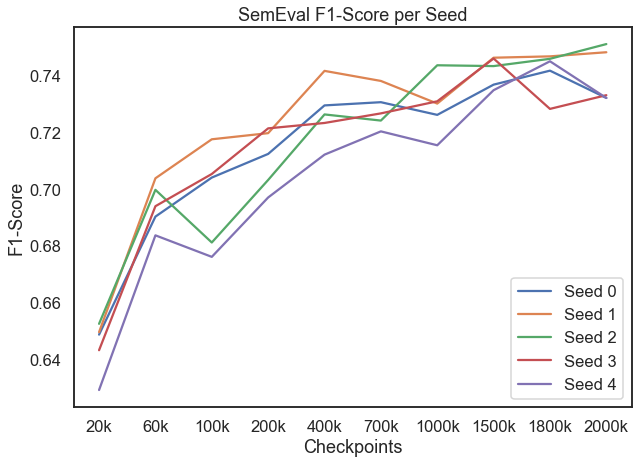

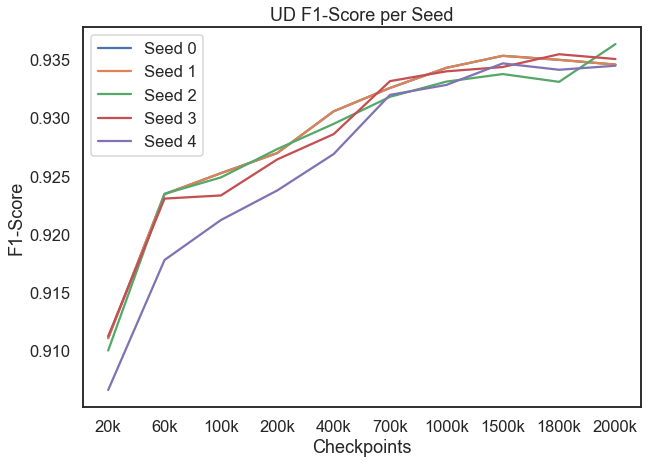

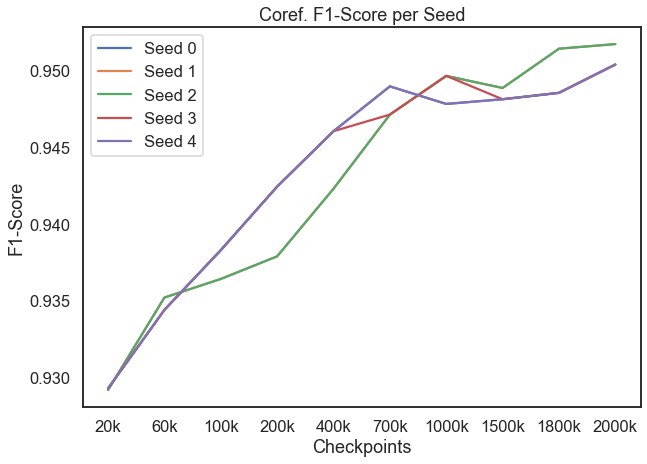

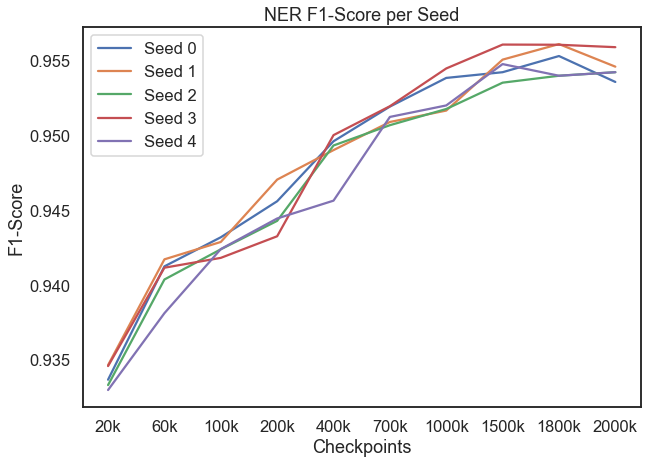

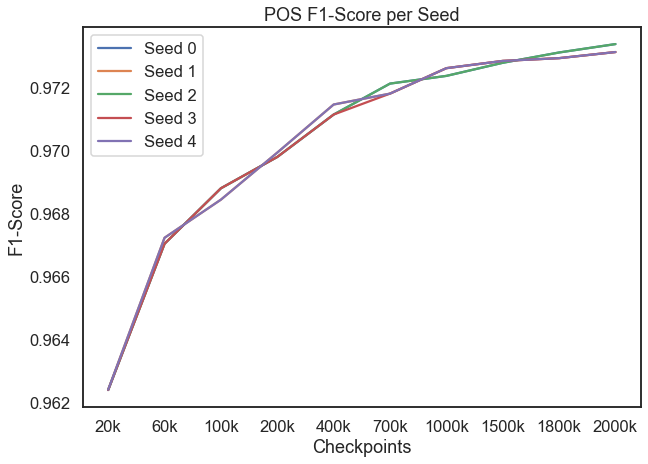

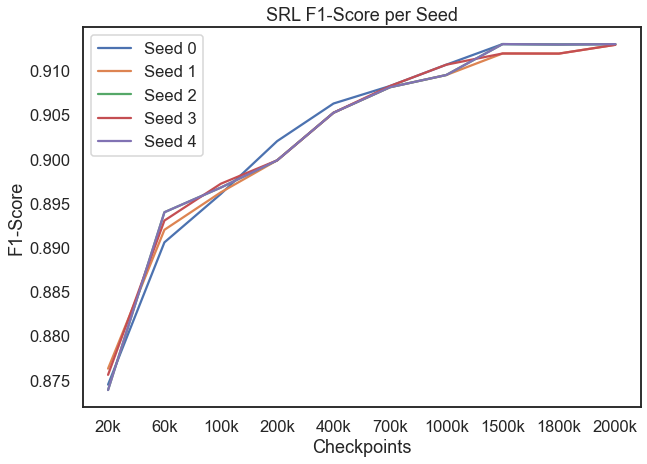

In [66]:
for i, df in enumerate(dfs):
    plot_metric_seeds(seeds, checkpoints, dfs[df], task_names[i])

In [ ]:
plot_metric_seeds(seeds, checkpoints, metrics[metric], task_names[i])

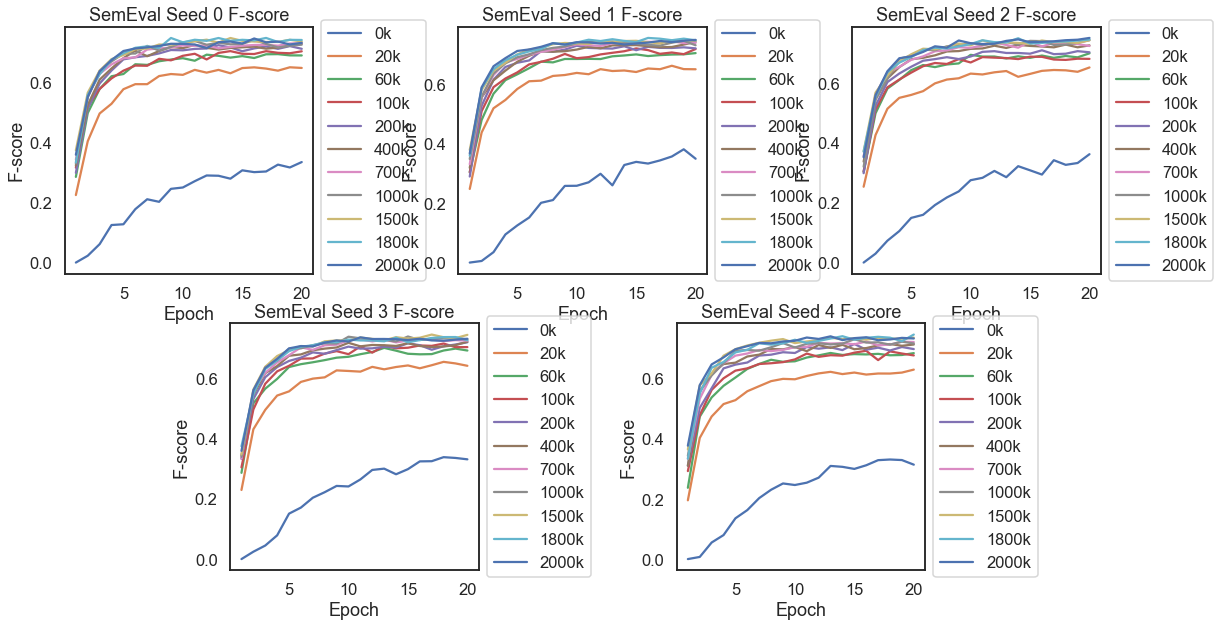

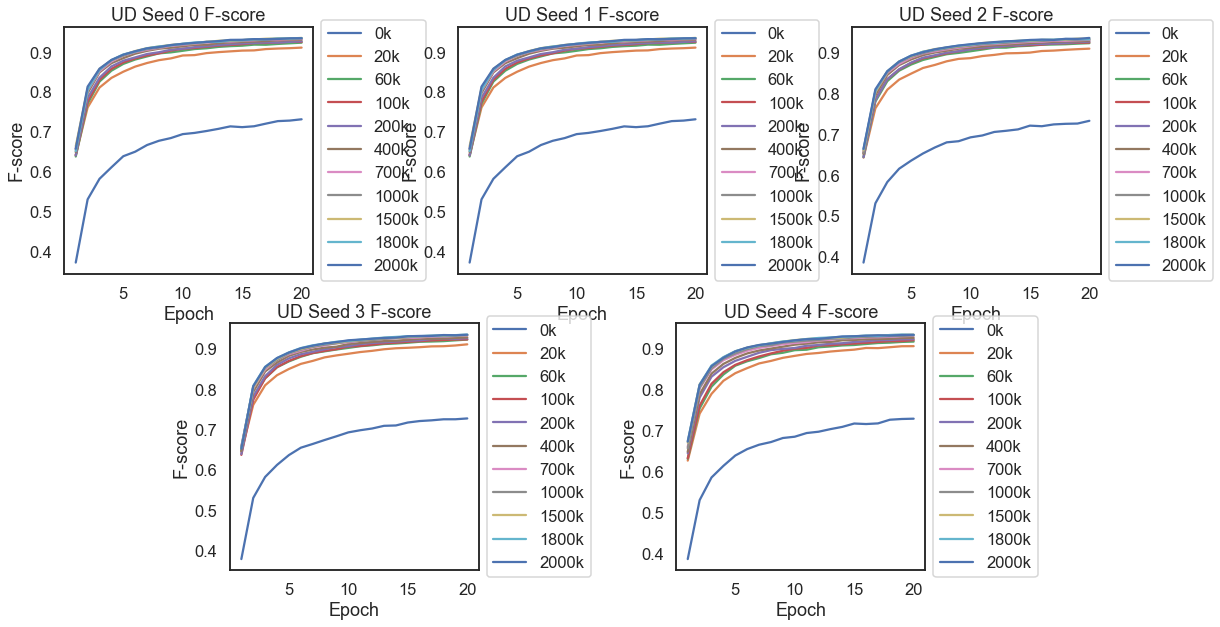

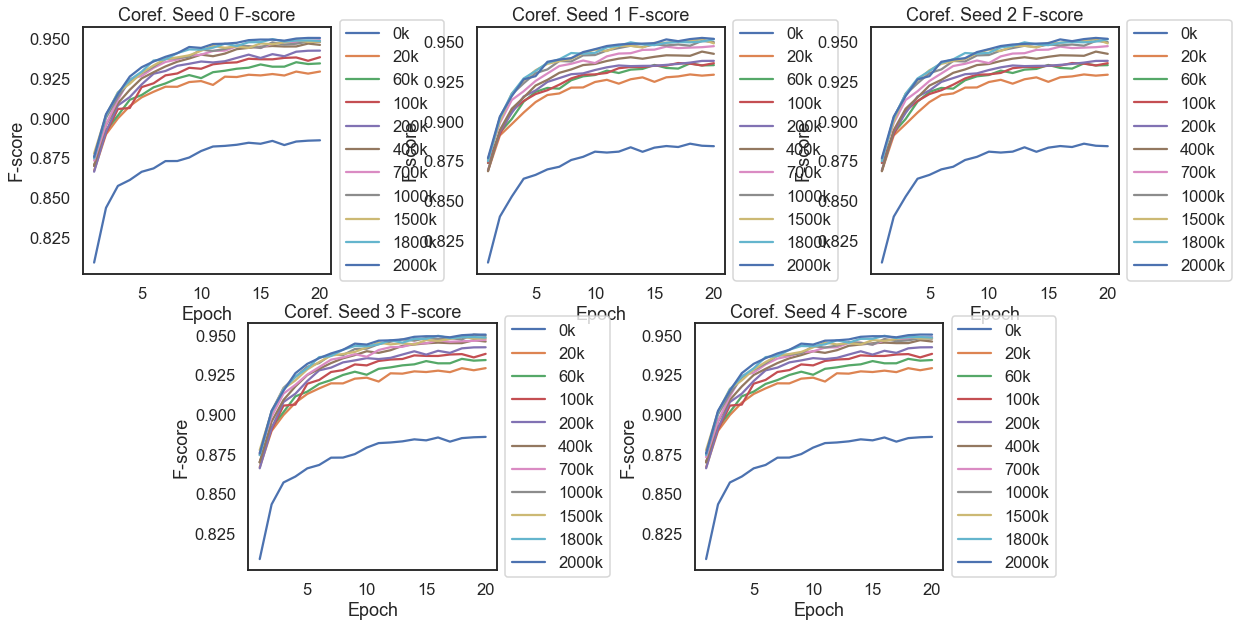

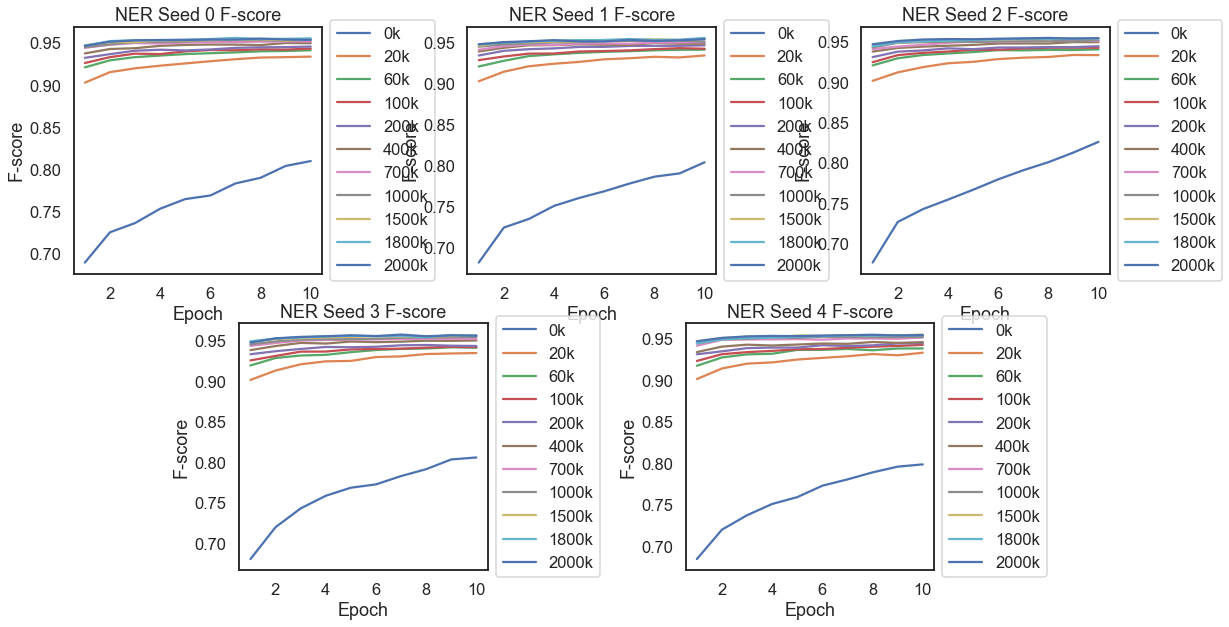

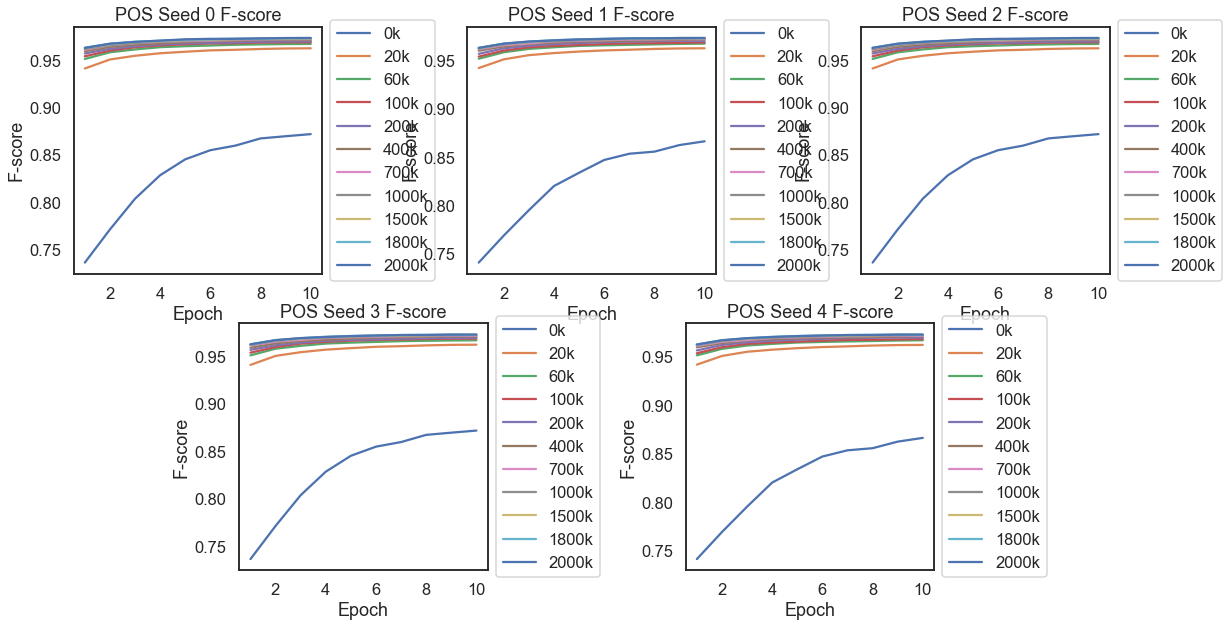

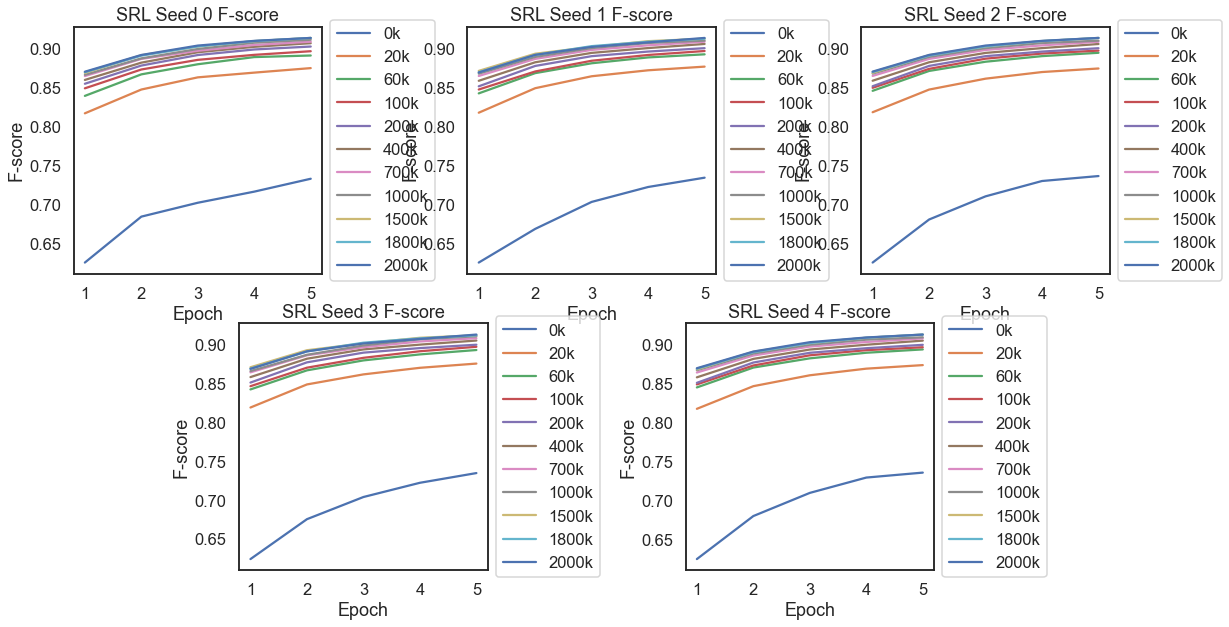

In [46]:
for i, metric in enumerate(metrics):
    plot_metric_epoch(seeds, checkpoints, metrics[metric], 'F-score', task_names[i])
    print('='*117)

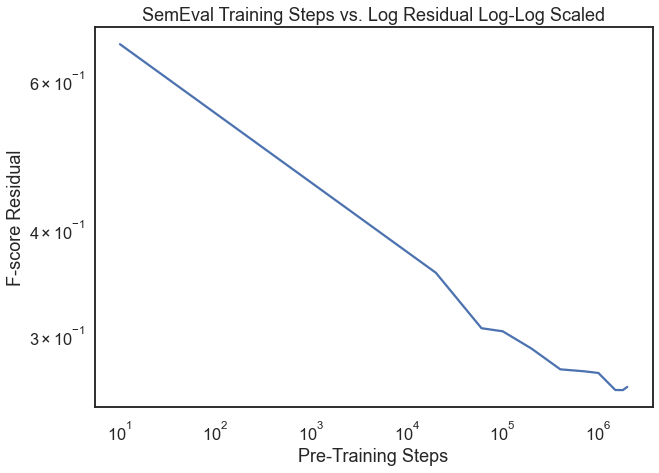

In [47]:
plot_log_residual(dfs['semeval'], 'F-score', 'SemEval')

In [48]:
params = {
    'input_module': 'MultiBertGunjanPatrick/multiberts-seed-4',
    'transfer_mode': 'frozen',
    'output_mode': 'mix',
    'max_layer': -1
}

task_params = {
    'span_pooling': 'attn',
    'n_spans': 2,
    'n_classes': 19,
    'single_sided': False,
    'cls_type': 'mlp',
    'dropout': 0.2
}

In [49]:
#n_classes = [19, 49, 2, 18, 48, 66]
#tasks = ['semeval', 'ud', 'ontonotes/coref', 'ontonotes/ner', 'ontonotes/pos', 'ontonotes/srl']
#weights = {}
#for i, task in enumerate(tasks):
#    task_params['n_classes'] = n_classes[i]
#    weights[task] = get_layer_weights(params, task_params, 'aws_bucket/models/{}'.format(task))

In [50]:
weights = load_pickle('weights/weights_dict.pkl')

No handles with labels found to put in legend.


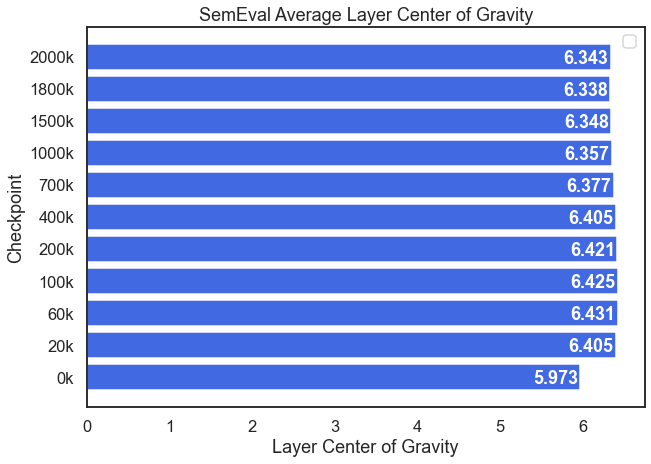

No handles with labels found to put in legend.


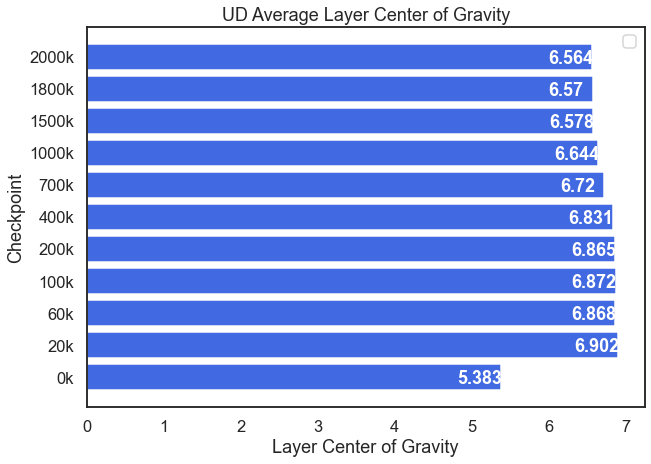

No handles with labels found to put in legend.


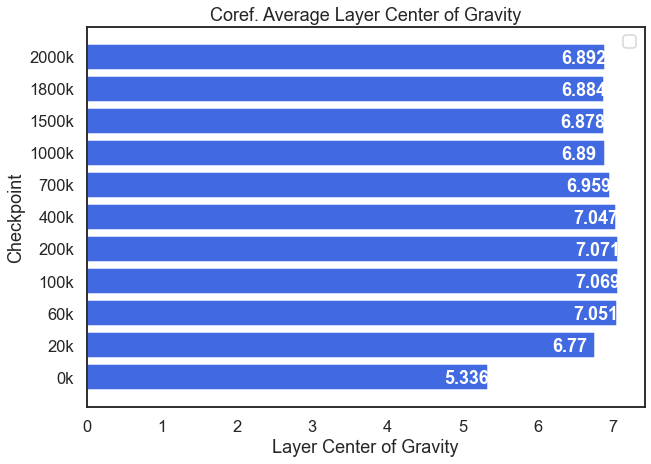

No handles with labels found to put in legend.


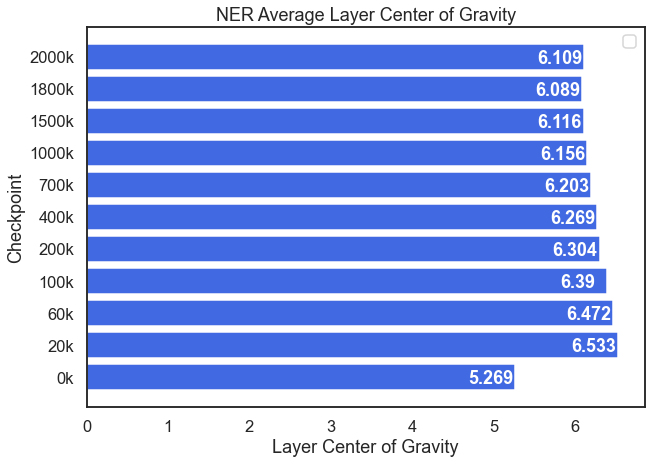

No handles with labels found to put in legend.


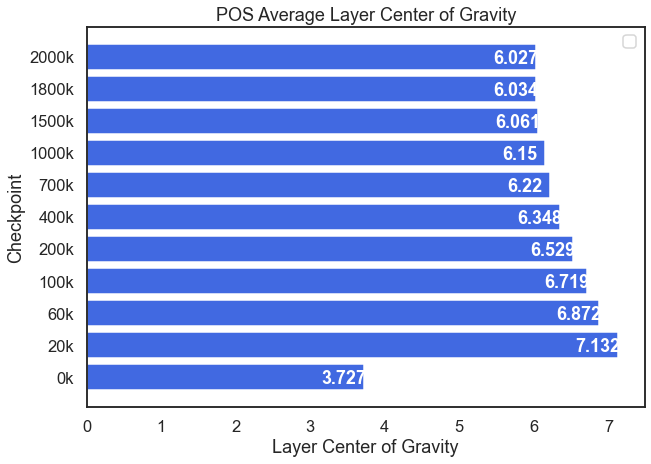

No handles with labels found to put in legend.


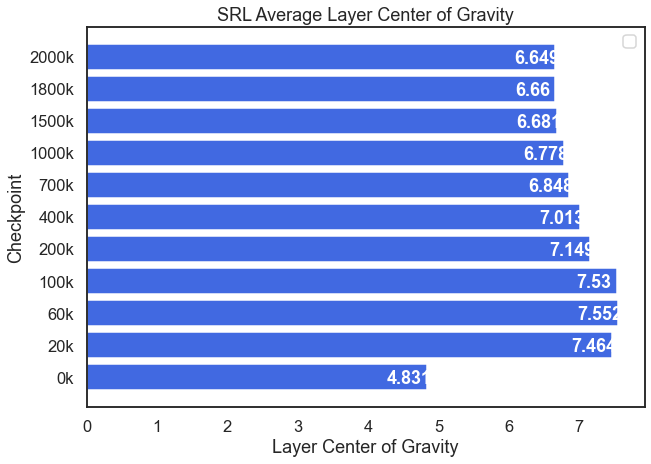

In [51]:
for i, weight in enumerate(weights):
    plot_cog(seeds, checkpoints, weights[weight], task_names[i])

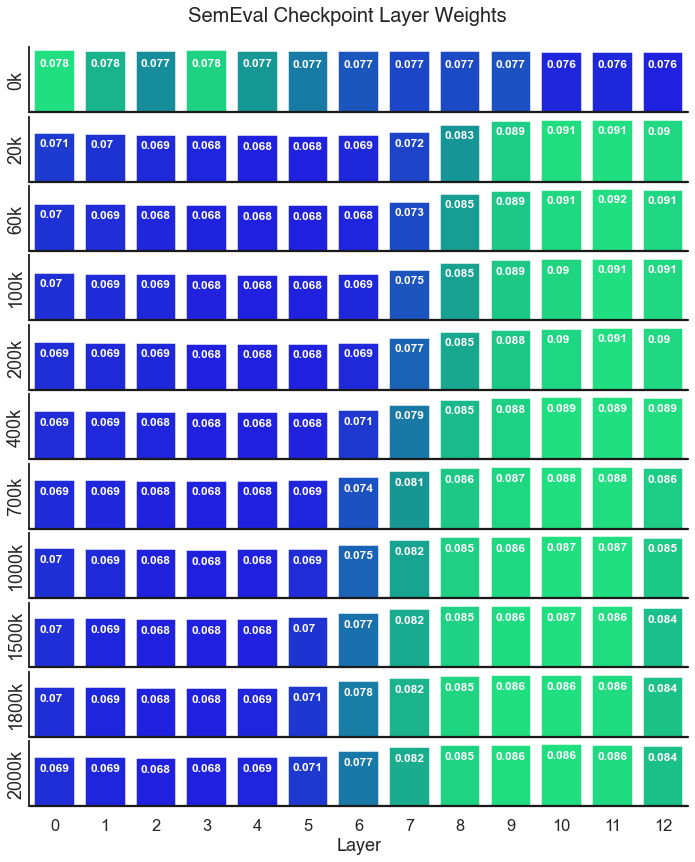

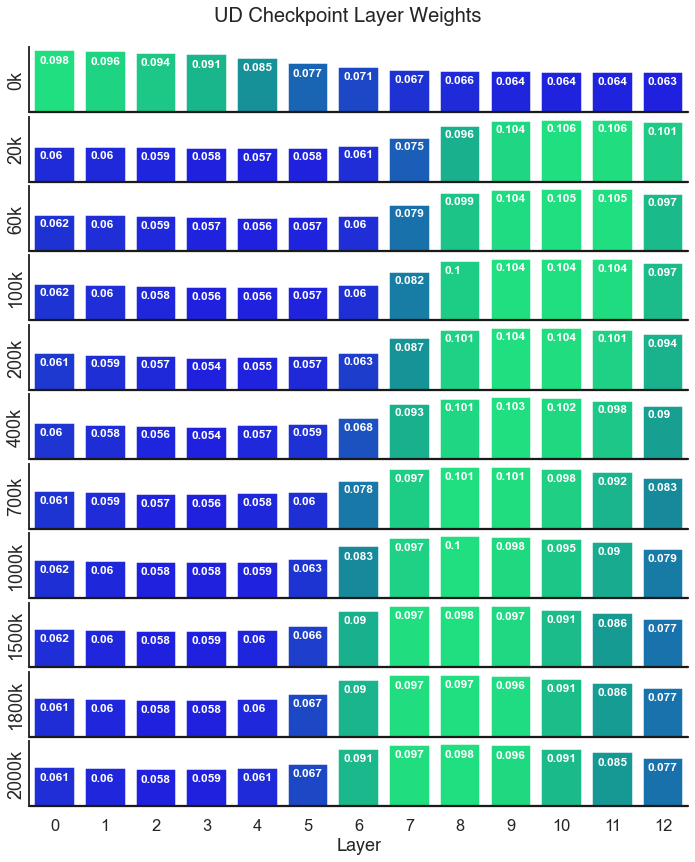

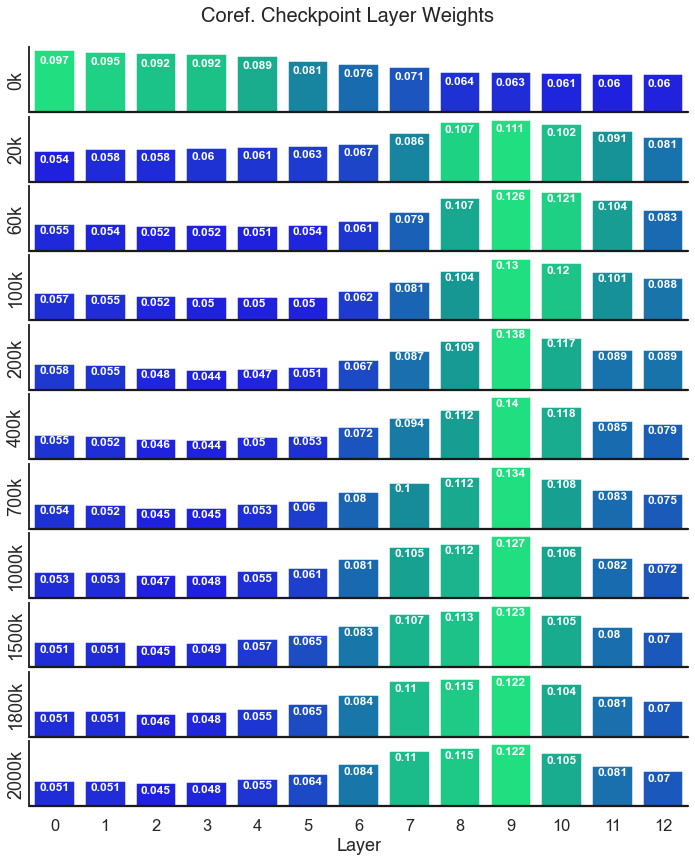

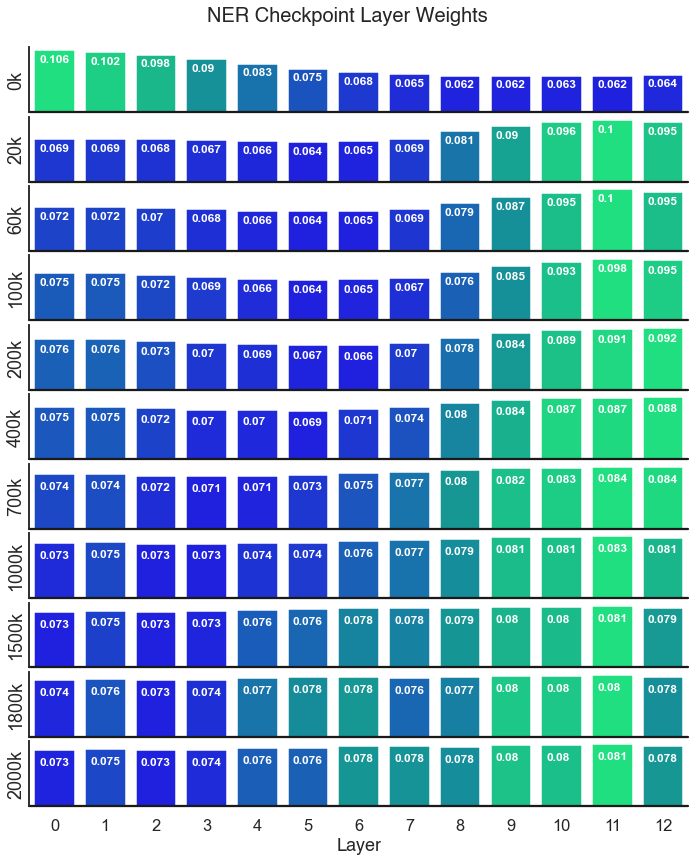

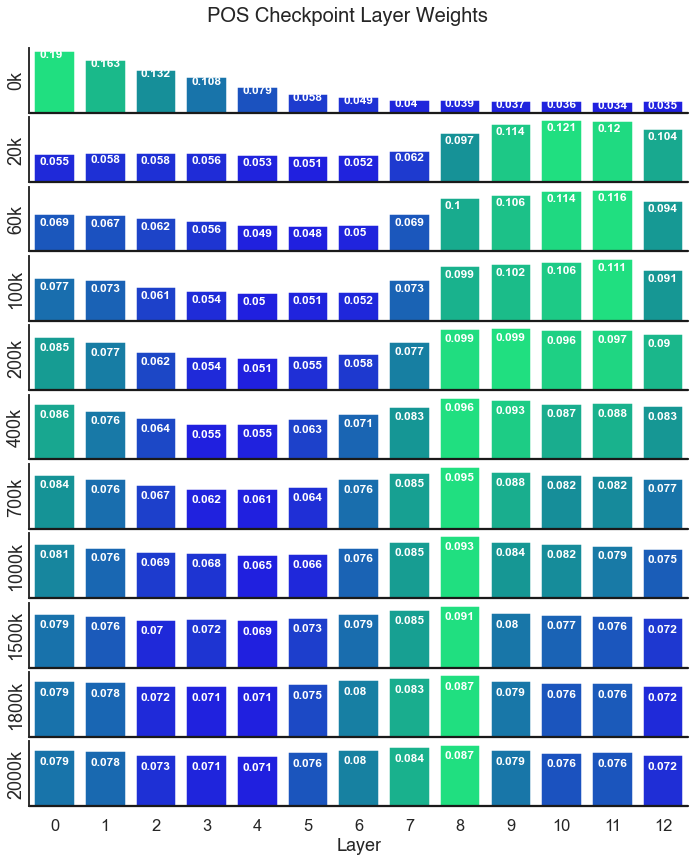

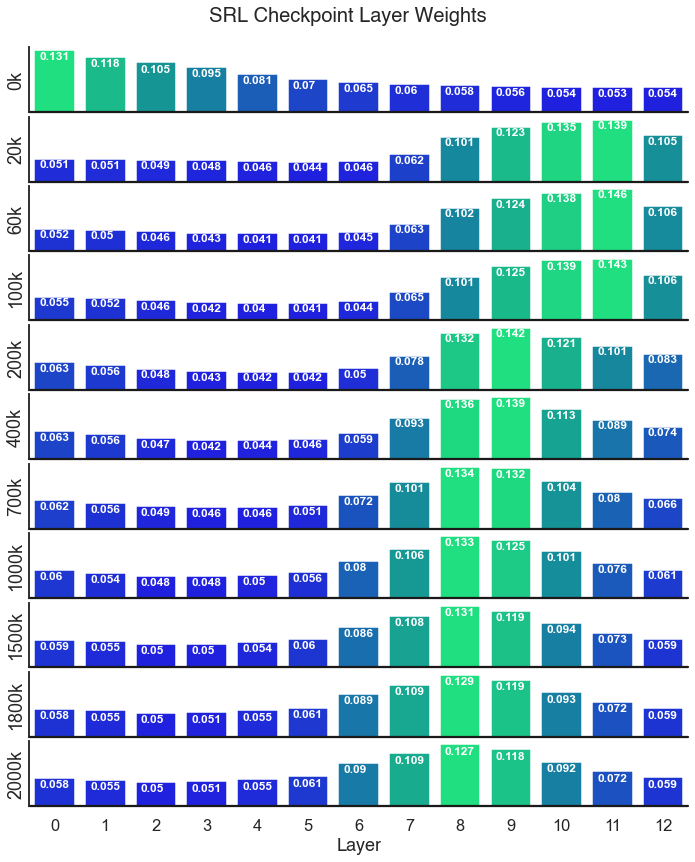

In [52]:
for i, weight in enumerate(weights):
    plot_layer_weight(seeds, checkpoints, weights[weight], task_names[i])

In [53]:
weights_dfs = {weight: weights_df(seeds, checkpoints, weights[weight]) for weight in weights}

In [143]:
print(dfs['ud'].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  seed-0 &  seed-1 &  seed-2 &  seed-3 &  seed-4 &  average \\
\midrule
0k    &   0.732 &   0.732 &   0.733 &   0.728 &   0.729 &    0.731 \\
20k   &   0.911 &   0.911 &   0.910 &   0.911 &   0.907 &    0.910 \\
60k   &   0.923 &   0.923 &   0.923 &   0.923 &   0.918 &    0.922 \\
100k  &   0.925 &   0.925 &   0.925 &   0.923 &   0.921 &    0.924 \\
200k  &   0.927 &   0.927 &   0.927 &   0.926 &   0.924 &    0.926 \\
400k  &   0.931 &   0.931 &   0.929 &   0.929 &   0.927 &    0.929 \\
700k  &   0.933 &   0.933 &   0.932 &   0.933 &   0.932 &    0.932 \\
1000k &   0.934 &   0.934 &   0.933 &   0.934 &   0.933 &    0.934 \\
1500k &   0.935 &   0.935 &   0.934 &   0.934 &   0.935 &    0.935 \\
1800k &   0.935 &   0.935 &   0.933 &   0.935 &   0.934 &    0.935 \\
2000k &   0.935 &   0.935 &   0.936 &   0.935 &   0.934 &    0.935 \\
\bottomrule
\end{tabular}



In [136]:
print(weights_dfs['ud'].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  seed-0 &  seed-1 &  seed-2 &  seed-3 &  seed-4 &  average \\
\midrule
0k    &   5.416 &   5.362 &   5.337 &   5.403 &   5.398 &    5.383 \\
20k   &   6.887 &   6.903 &   6.881 &   6.903 &   6.935 &    6.902 \\
60k   &   6.868 &   6.867 &   6.851 &   6.857 &   6.894 &    6.868 \\
100k  &   6.855 &   6.876 &   6.834 &   6.864 &   6.931 &    6.872 \\
200k  &   6.855 &   6.851 &   6.851 &   6.857 &   6.914 &    6.865 \\
400k  &   6.828 &   6.810 &   6.824 &   6.798 &   6.894 &    6.831 \\
700k  &   6.725 &   6.702 &   6.679 &   6.724 &   6.768 &    6.720 \\
1000k &   6.618 &   6.616 &   6.654 &   6.642 &   6.690 &    6.644 \\
1500k &   6.577 &   6.516 &   6.613 &   6.611 &   6.575 &    6.578 \\
1800k &   6.574 &   6.506 &   6.617 &   6.594 &   6.557 &    6.570 \\
2000k &   6.541 &   6.501 &   6.624 &   6.595 &   6.560 &    6.564 \\
\bottomrule
\end{tabular}



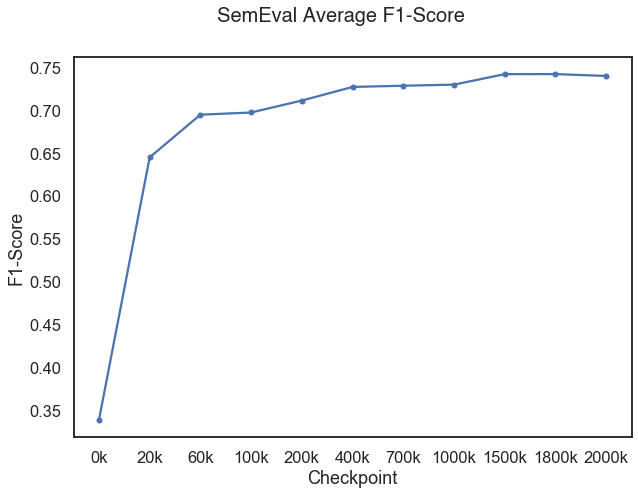

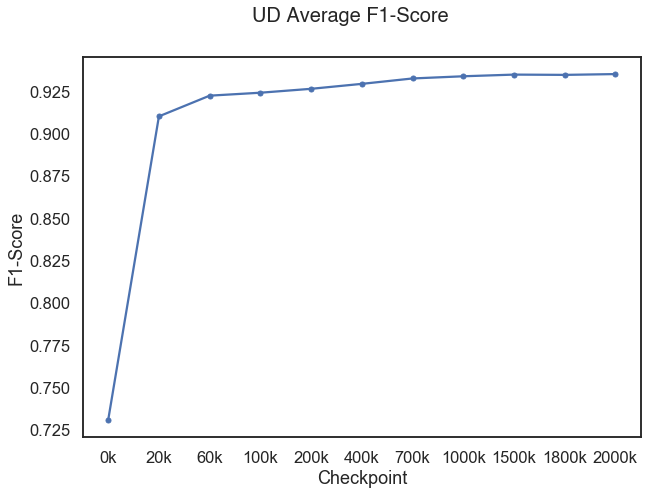

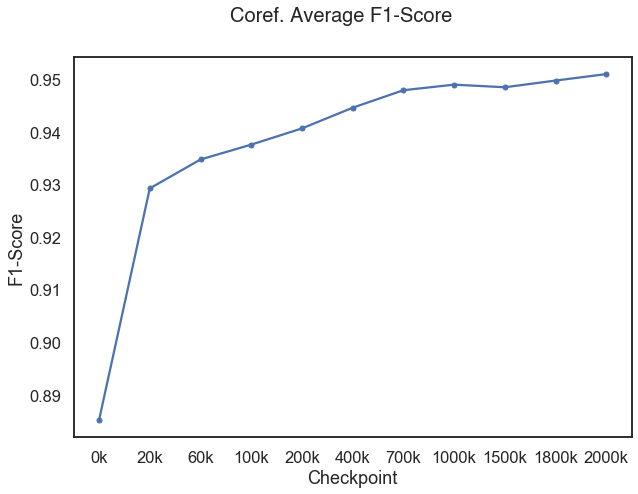

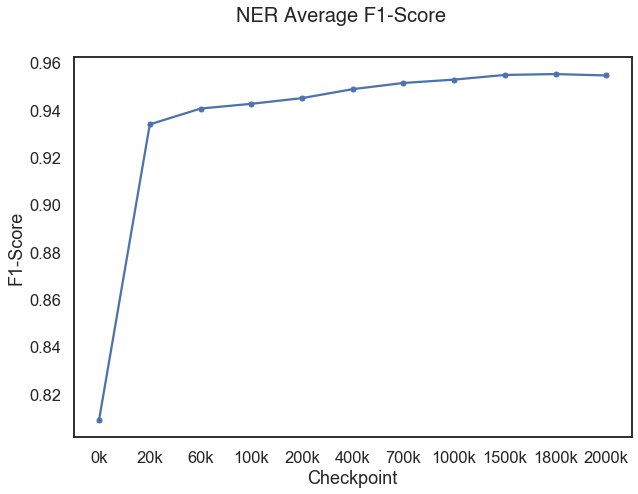

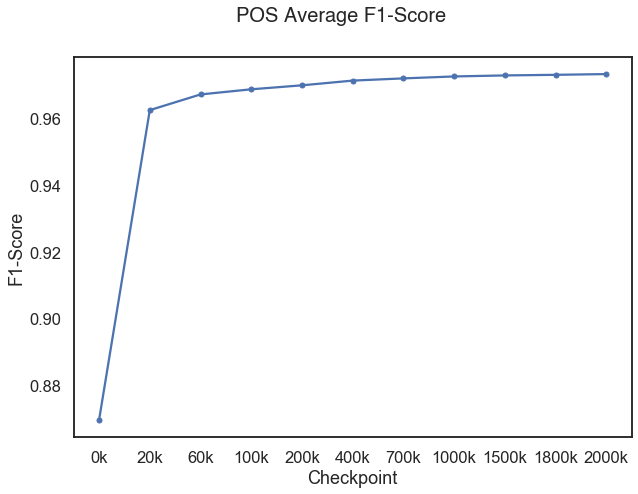

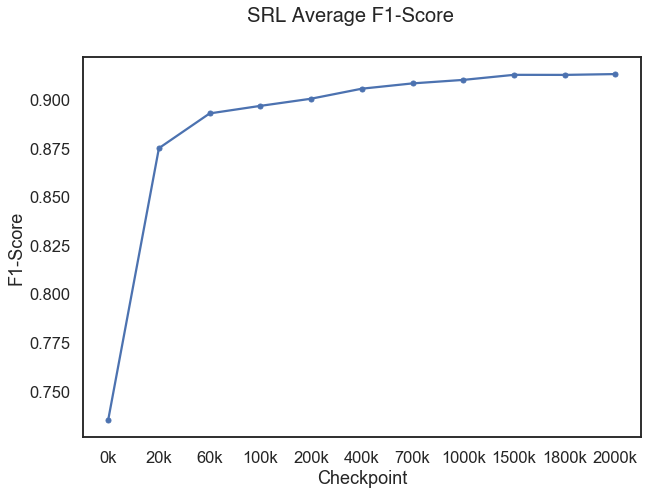

In [56]:
for i, task in enumerate(dfs):
    plot_metric(seeds, dfs[task], task_names[i], 'F1-Score')

In [57]:
for i, task in enumerate(dfs):
    plot_metric_against_0k(seeds, dfs[task], task_names[i], 'F-Score')

NameError: name 'plot_metric_against_0k' is not defined

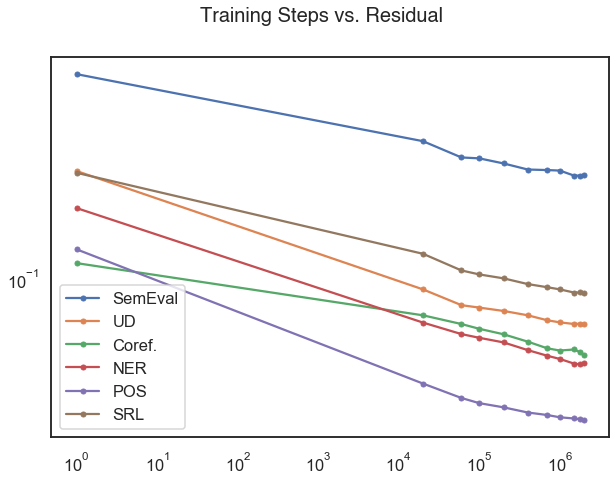

In [67]:
plot_log_residual_all(seeds, dfs, task_names)

In [68]:
def plot_learning_curve(seeds, dfs, task_names):
    checkpoints = ['20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
    checkpoints_pre = ['0k', '20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k']
    fig, ax = plt.subplots(figsize=(10,7))
    for i, task in enumerate(dfs):
        ratio = []
        for j in range(len(checkpoints)):
            ratio.append(dfs[task].loc[checkpoints[j], 'average']/dfs[task].loc[checkpoints_pre[j], 'average'])
        ax.plot(range(len(checkpoints)), ratio, '-o',  markersize=5, label=task_names[i])
    plt.xticks(list(range(len(checkpoints))),checkpoints)
    ax.legend()
    ax.set_ylim([0.98, 1.05])
    ax.set_xlabel('Checkpoints')
    ax.set_ylabel('Ratio')
    fig.suptitle('Relative F1-Scores Increase', fontname = 'Helvetica', size=20)
    plt.show()

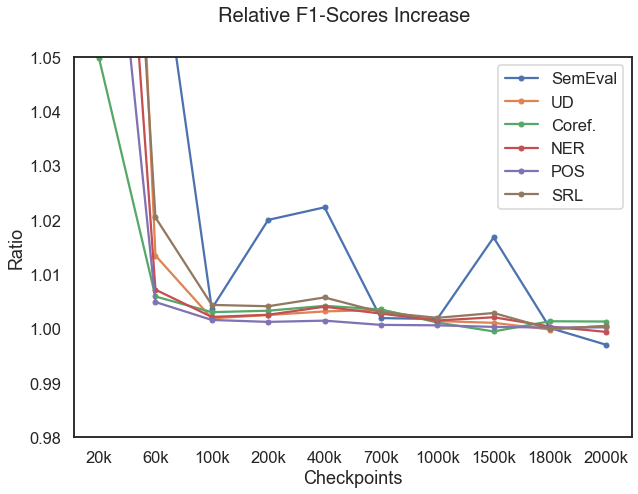

In [69]:
plot_learning_curve(seeds, dfs, task_names)

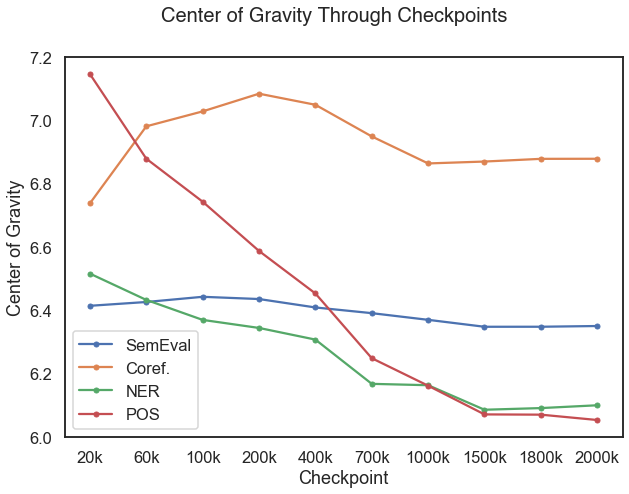

In [70]:
compare_cogs(weights, ['semeval', 'ontonotes/coref', 'ontonotes/ner', 'ontonotes/pos'], 
             ['SemEval', 'Coref.', 'NER', 'POS'])

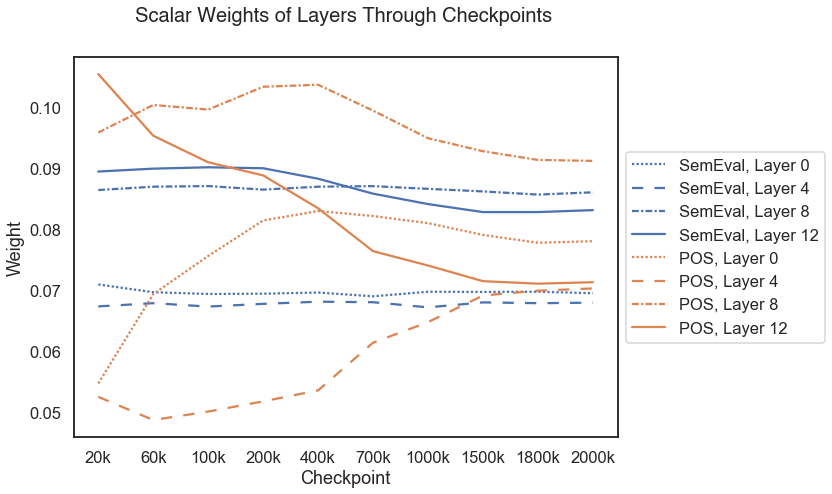

In [71]:
compare_weights(weights, ['semeval', 'ontonotes/pos'], 
             ['SemEval', 'POS'], [0,4,8,12])

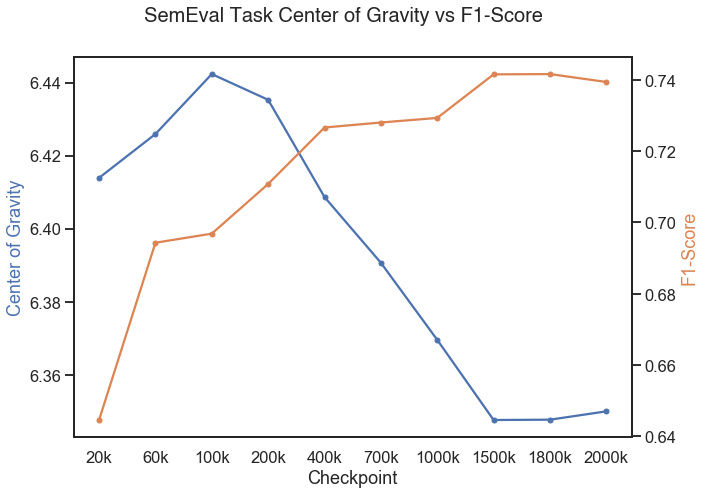

In [72]:
cog_vs_metric(weights['semeval'], dfs['semeval'], 'SemEval', 'F1-Score')

In [73]:
average_df = {}
for task in dfs:
    average_df[task] = round(dfs[task]['average'], 3)
average_df = pd.DataFrame(average_df, index=checkpoints, )

In [74]:
average_df = average_df.rename(columns={'semeval':'SemEval', 'ud':'UD', 'ontonotes/coref':'Coref',
                           'ontonotes/ner':'NER', 'ontonotes/pos':'POS', 'ontonotes/srl':'SRL'})

In [75]:
checkpoints_lama = ['0k', '20k', '60k', '100k', '140k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']
lama_google = pd.DataFrame(np.load('results/lama/google_mean_p10_np.npy').T, index=checkpoints_lama, columns=seeds)
lama_google = lama_google.drop(index=['140k'])
lama_squad = pd.DataFrame(np.load('results/lama/squad_all_p10_np.npy')[0].T, index=checkpoints_lama, columns=seeds)
lama_squad = lama_squad.drop(index=['140k'])
lama_google['Average'] = (lama_google['seed-0'] + lama_google['seed-1'] + lama_google['seed-2'] + lama_google['seed-3'] + lama_google['seed-4'])/5
lama_squad['Average'] = (lama_squad['seed-0'] + lama_squad['seed-1'] + lama_squad['seed-2'] + lama_squad['seed-3'] + lama_squad['seed-4'])/5
dfs_lama = {'Google RE PoB':lama_google, 'SQuAD':lama_squad}

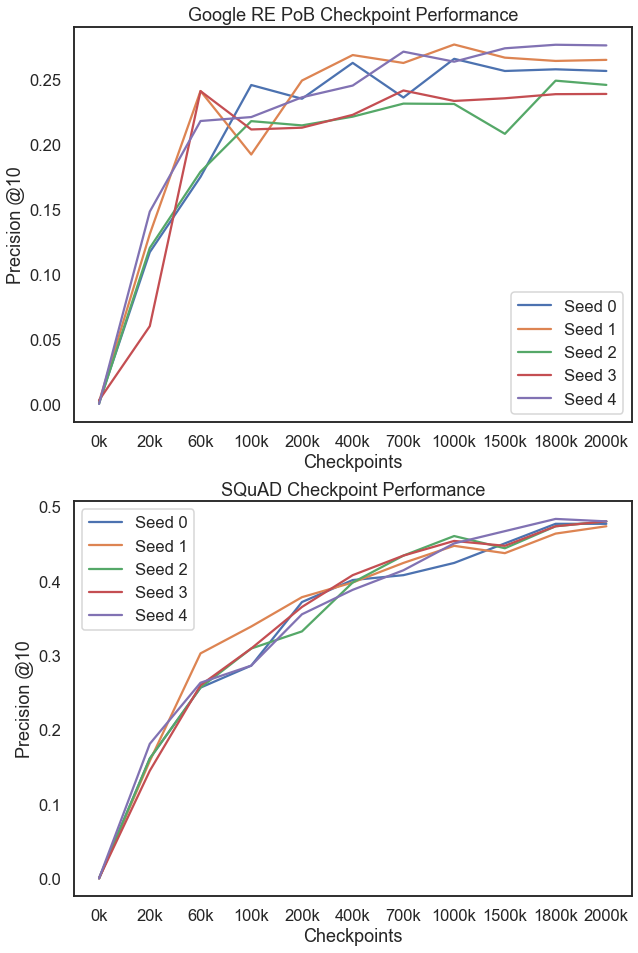

In [76]:
plot_lama(seeds, checkpoints, dfs_lama)

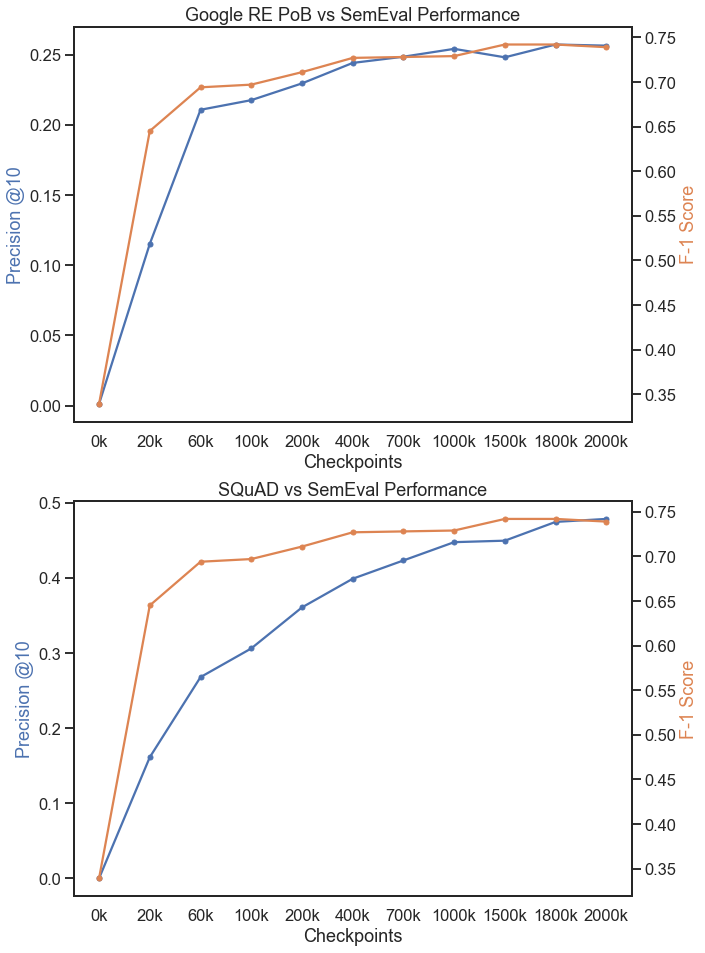

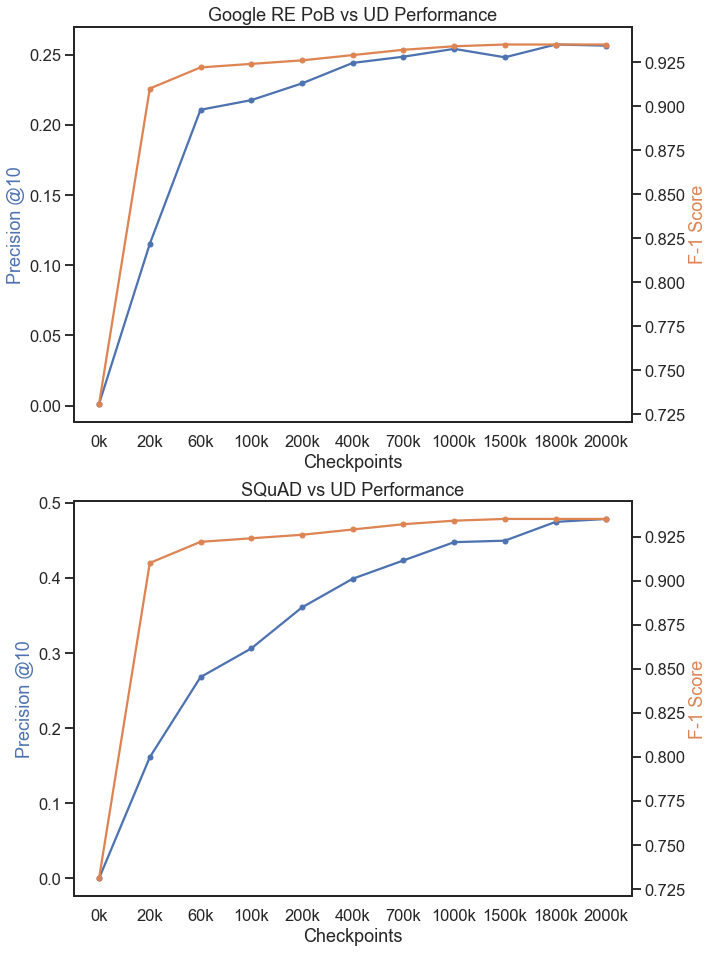

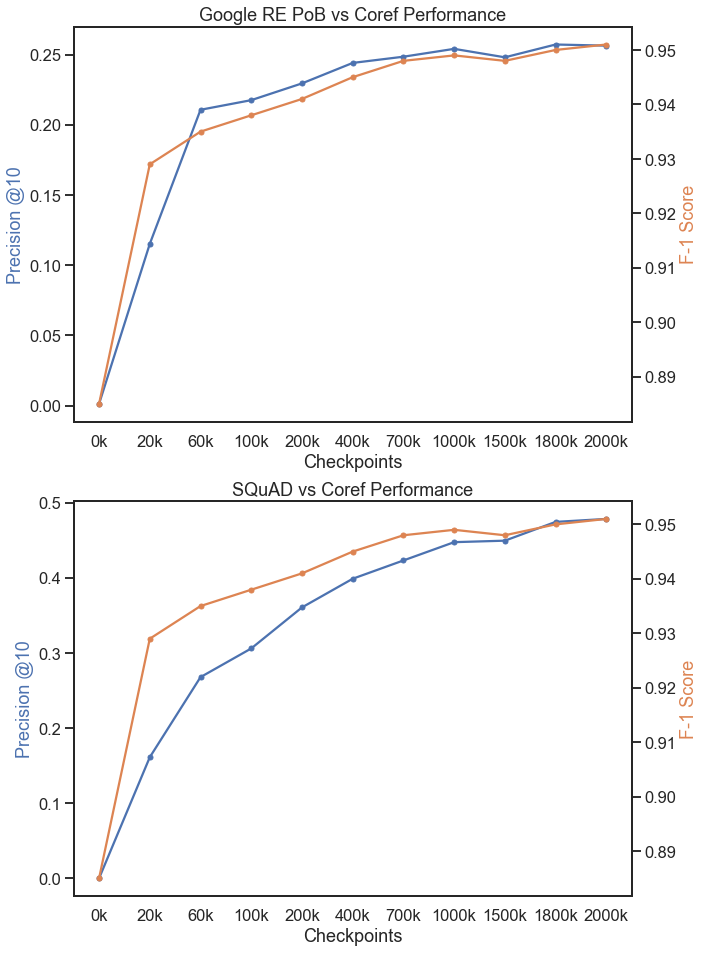

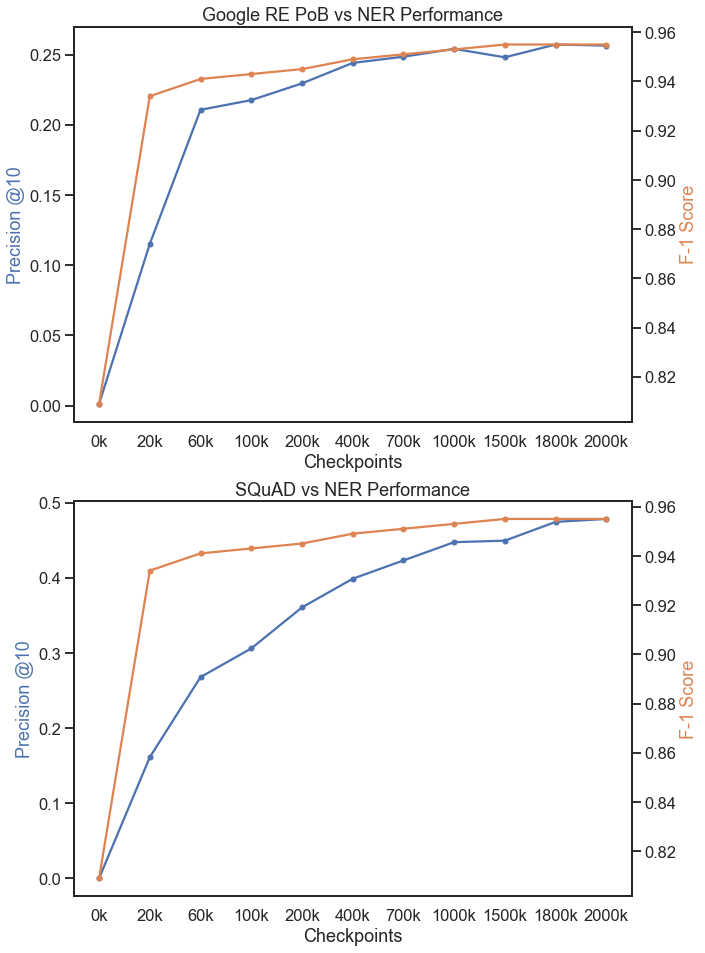

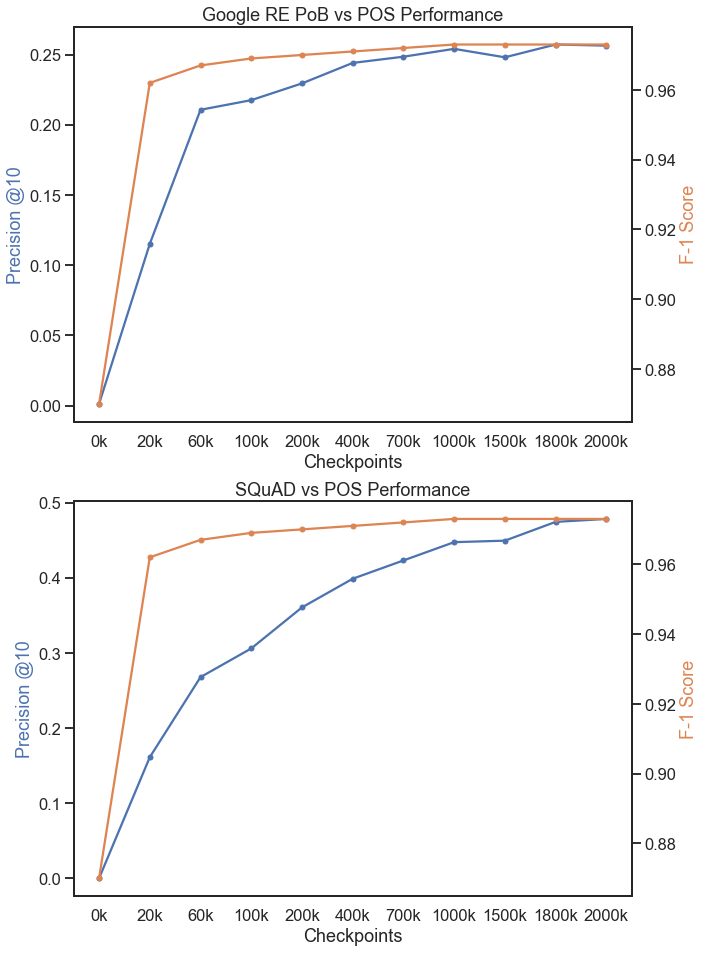

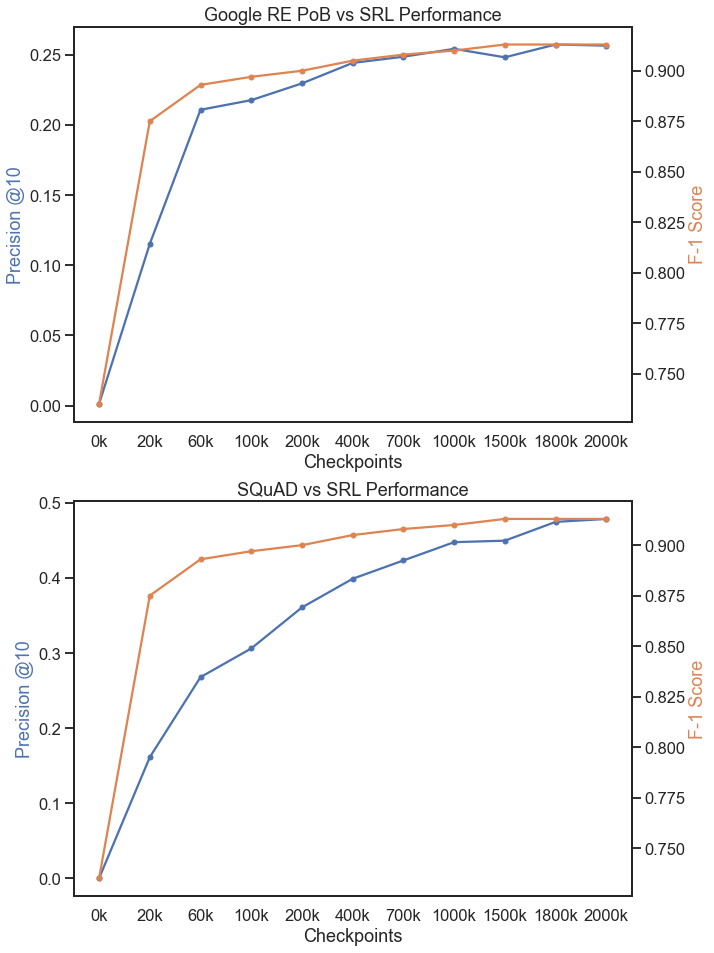

In [77]:
for task in average_df:
    lama_vs_lin(seeds, checkpoints, dfs_lama, average_df, task)

In [84]:
dfs['ontonotes/coref'].drop(columns='average').T.describe()

0k       20k       60k      100k      200k      400k      700k  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.885234  0.929239  0.934729  0.937552  0.940633  0.944568  0.947890   
std    0.000984  0.000057  0.000441  0.001030  0.002494  0.002057  0.001009   
min    0.884155  0.929176  0.934407  0.936424  0.937902  0.942314  0.947153   
25%    0.884155  0.929176  0.934407  0.936424  0.937902  0.942314  0.947153   
50%    0.885953  0.929281  0.934407  0.938305  0.942454  0.946070  0.947153   
75%    0.885953  0.929281  0.935212  0.938305  0.942454  0.946070  0.948996   
max    0.885953  0.929281  0.935212  0.938305  0.942454  0.946070  0.948996   

          1000k     1500k     1800k     2000k  
count  5.000000  5.000000  5.000000  5.000000  
mean   0.948948  0.948450  0.949727  0.950956  
std    0.001003  0.000402  0.001579  0.000731  
min    0.947849  0.948156  0.948574  0.950423  
25%    0.947849  0.948156  0.948574  0.950423  
50%    0.949681  0.948156  0.948574  0.950423  
75%    0.949681  0.948890  0.951456  0.951757  
max    0.949681  0.948890  0.951456  0.951757

In [83]:
dfs['ontonotes/pos'].drop(columns='average').T.describe()

0k       20k       60k      100k      200k      400k      700k  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.869636  0.962414  0.967116  0.968652  0.969843  0.971257  0.971920   
std    0.003032  0.000005  0.000104  0.000197  0.000076  0.000174  0.000174   
min    0.866314  0.962411  0.967040  0.968437  0.969788  0.971130  0.971793   
25%    0.866314  0.962411  0.967040  0.968437  0.969788  0.971130  0.971793   
50%    0.871850  0.962411  0.967040  0.968796  0.969788  0.971130  0.971793   
75%    0.871850  0.962420  0.967230  0.968796  0.969926  0.971448  0.972110   
max    0.871850  0.962420  0.967230  0.968796  0.969926  0.971448  0.972110   

          1000k     1500k     1800k     2000k  
count  5.000000  5.000000  5.000000  5.000000  
mean   0.972501  0.972804  0.972988  0.973210  
std    0.000134  0.000033  0.000098  0.000138  
min    0.972354  0.972769  0.972916  0.973109  
25%    0.972354  0.972769  0.972916  0.973109  
50%    0.972599  0.972828  0.972916  0.973109  
75%    0.972599  0.972828  0.973095  0.973361  
max    0.972599  0.972828  0.973095  0.973361

In [137]:
weights_dfs['semeval'].to_latex()

seed-0    seed-1    seed-2    seed-3    seed-4   average
0k     5.974336  5.951303  5.991377  5.971922  5.977600  5.973308
20k    6.413898  6.413116  6.383612  6.401045  6.414186  6.405171
60k    6.425899  6.431581  6.439027  6.409625  6.448656  6.430957
100k   6.442311  6.419805  6.415501  6.417343  6.429724  6.424937
200k   6.435266  6.429436  6.399939  6.413489  6.428546  6.421336
400k   6.408652  6.417425  6.398369  6.381071  6.420786  6.405261
700k   6.390659  6.381321  6.358797  6.380151  6.373197  6.376825
1000k  6.369565  6.362073  6.353945  6.329454  6.367477  6.356503
1500k  6.347625  6.358698  6.360380  6.318838  6.356505  6.348409
1800k  6.347712  6.350756  6.321484  6.325420  6.345350  6.338144
2000k  6.349995  6.347155  6.344271  6.323956  6.347917  6.342659

In [122]:
df_avg = []

for task in dfs:
    df_avg.append(dfs[task]['average'])

In [126]:
print(pd.DataFrame(np.array(df_avg).T, columns=['Relations', 'Dep.', 'Coref.', 'NER', 'POS', 'SRL'],
             index=checkpoints).to_latex(float_format="%.3f", caption='Average performance of all linguistic tasks per BERT checkpoint.'))

\begin{table}
\centering
\caption{Average performance of all linguistic tasks per BERT checkpoint.}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Relations &  Dep. &  Coref. &   NER &   POS &   SRL \\
\midrule
0k    &      0.339 & 0.731 &   0.885 & 0.809 & 0.870 & 0.735 \\
20k   &      0.645 & 0.910 &   0.929 & 0.934 & 0.962 & 0.875 \\
60k   &      0.694 & 0.922 &   0.935 & 0.941 & 0.967 & 0.893 \\
100k  &      0.697 & 0.924 &   0.938 & 0.943 & 0.969 & 0.897 \\
200k  &      0.711 & 0.926 &   0.941 & 0.945 & 0.970 & 0.900 \\
400k  &      0.727 & 0.929 &   0.945 & 0.949 & 0.971 & 0.905 \\
700k  &      0.728 & 0.932 &   0.948 & 0.951 & 0.972 & 0.908 \\
1000k &      0.729 & 0.934 &   0.949 & 0.953 & 0.973 & 0.910 \\
1500k &      0.742 & 0.935 &   0.948 & 0.955 & 0.973 & 0.913 \\
1800k &      0.742 & 0.935 &   0.950 & 0.955 & 0.973 & 0.913 \\
2000k &      0.739 & 0.935 &   0.951 & 0.955 & 0.973 & 0.913 \\
\bottomrule
\end{tabular}
\end{table}



In [127]:
df_avg = []

for task in weights_dfs:
    df_avg.append(weights_dfs[task]['average'])

In [129]:
print(pd.DataFrame(np.array(df_avg).T, columns=['Relations', 'Dep.', 'Coref.', 'NER', 'POS', 'SRL'],
             index=checkpoints).to_latex(float_format="%.3f", caption='Layer center of gravities of all linguistic tasks per BERT checkpoint.'))

\begin{table}
\centering
\caption{Layer center of gravities of all linguistic tasks per BERT checkpoint.}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Relations &  Dep. &  Coref. &   NER &   POS &   SRL \\
\midrule
0k    &      5.973 & 5.383 &   5.336 & 5.269 & 3.727 & 4.831 \\
20k   &      6.405 & 6.902 &   6.770 & 6.533 & 7.132 & 7.464 \\
60k   &      6.431 & 6.868 &   7.051 & 6.472 & 6.872 & 7.552 \\
100k  &      6.425 & 6.872 &   7.069 & 6.390 & 6.719 & 7.530 \\
200k  &      6.421 & 6.865 &   7.071 & 6.304 & 6.529 & 7.149 \\
400k  &      6.405 & 6.831 &   7.047 & 6.269 & 6.348 & 7.013 \\
700k  &      6.377 & 6.720 &   6.959 & 6.203 & 6.220 & 6.848 \\
1000k &      6.357 & 6.644 &   6.890 & 6.156 & 6.150 & 6.778 \\
1500k &      6.348 & 6.578 &   6.878 & 6.116 & 6.061 & 6.681 \\
1800k &      6.338 & 6.570 &   6.884 & 6.089 & 6.034 & 6.660 \\
2000k &      6.343 & 6.564 &   6.892 & 6.109 & 6.027 & 6.649 \\
\bottomrule
\end{tabular}
\end{table}



# Task Adaptation

In [85]:
f_chemprot = [[0.7918, 0.8445, 0.8639, 0.8731, 0.8739, 0.8820, 0.8799, 0.8795, 0.882, 0.8829, 0.8816],
              [0.7982, 0.8365, 0.8635, 0.8711, 0.8687, 0.8783, 0.8855, 0.8833, 0.8815, 0.8775, 0.887],
              [0.7962, 0.8438, 0.869, 0.8646, 0.8737, 0.8596, 0.8764, 0.8803, 0.8830, 0.8815, 0.8914],
              [0.797, 0.8398, 0.8671, 0.8681, 0.8746, 0.8785, 0.8814, 0.8788, 0.8819, 0.8856, 0.8807],
              [0.7893, 0.8189, 0.8625, 0.8686, 0.8713, 0.8693, 0.8703, 0.8815, 0.8791, 0.8703, 0.8748]]

In [86]:
f_multi = [[0.7967, 0.8171, 0.8395, 0.8586, 0.8394, 0.8537, 0.825, 0.83, 0.842, 0.865, 0.8384],
           [0.7956, 0.8175, 0.8463, 0.8499, 0.8653, 0.85, 0.8571, 0.8787, 0.8508, 0.8672, 0.8797],
           [0.7977, 0.8159, 0.8395, 0.8588, 0.8638, 0.8674, 0.8536, 0.879, 0.8808, 0.8717, 0.8603],
           [0.7981, 0.8028, 0.8645, 0.8597, 0.8507, 0.8621, 0.8789, 0.8748, 0.8752, 0.8682, 0.8693],
           [0.7989, 0.8089, 0.8373, 0.8437, 0.864, 0.8348, 0.8659, 0.861, 0.8579, 0.8759, 0.8664]]

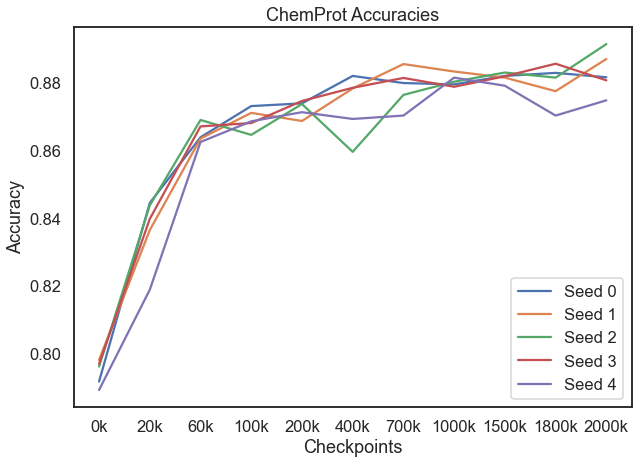

In [87]:
plot_finetuned(f_chemprot, 'ChemProt')

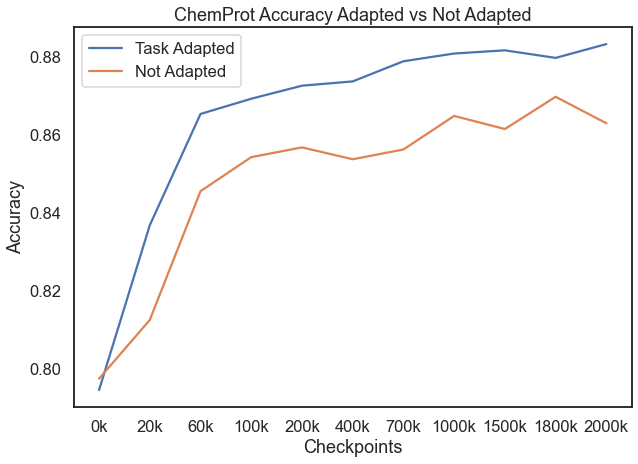

In [88]:
plot_finetuned_vs_not(f_chemprot, f_multi, 'ChemProt')

In [106]:
tasks_fine = ['ner', 'pos', 'ud', 'semeval', 'coref']
task_names_fine = ['NER', 'POS', 'UD', 'SemEval', 'Coref.']
seeds_fine = ['seed-0']
checkpoints_fine = ['0k', '20k', '60k', '100k', '200k', '400k', 
                   '700k', '1000k', '1500k', '1800k', '2000k']

In [107]:
metrics_fine = {x: get_metrics(seeds_fine, checkpoints_fine, 'results/{}/metrics'.format(x)) for x in tasks_fine}

In [108]:
dfs_fine = {metric: metric_df(seeds_fine, checkpoints_fine, metrics_fine[metric], 'F-score') for metric in metrics_fine}

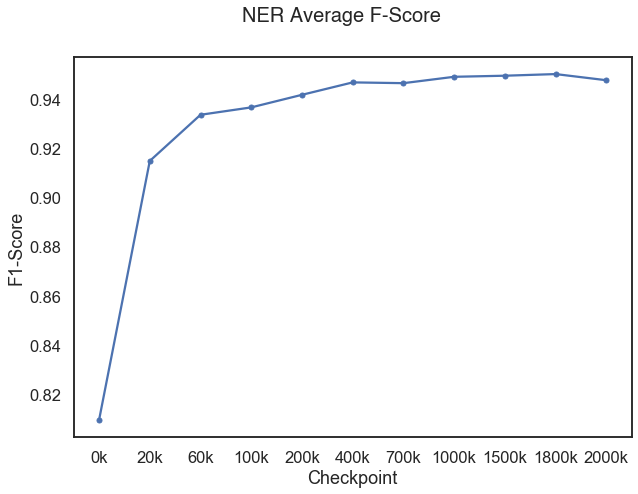

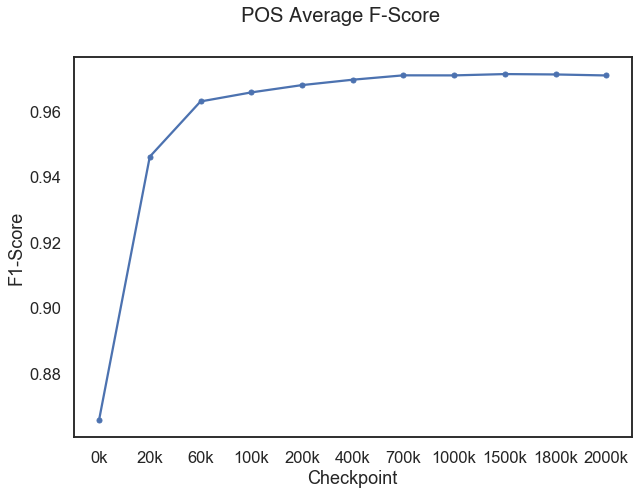

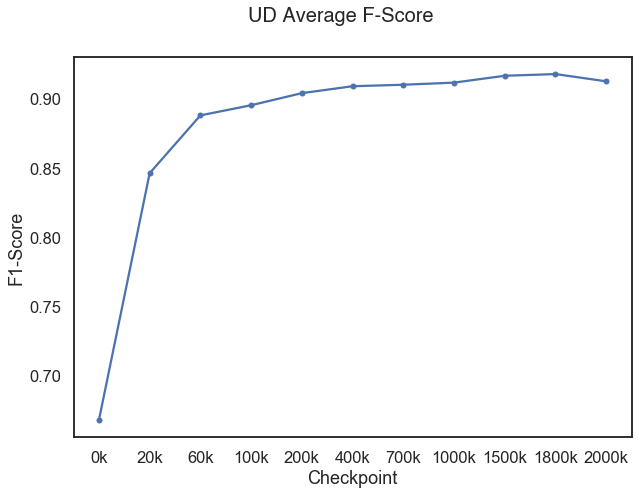

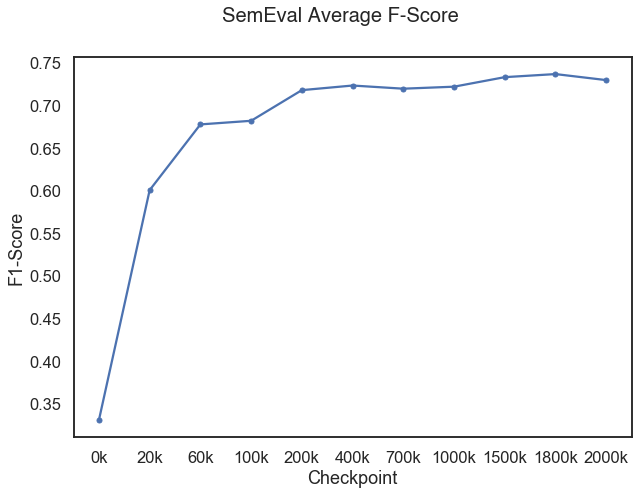

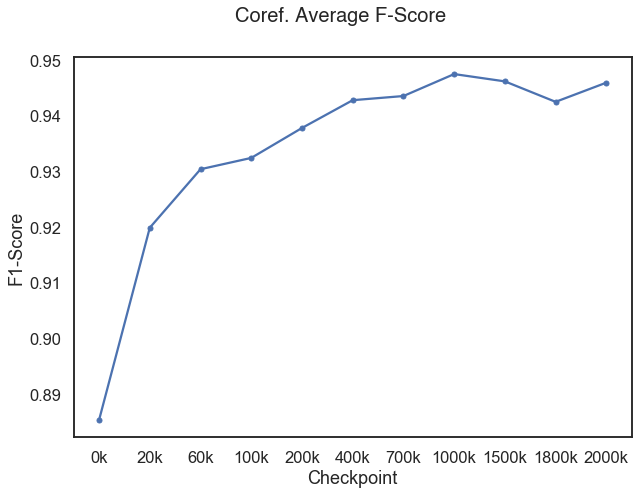

In [109]:
for i, task in enumerate(dfs_fine):
    plot_metric(seeds_fine, dfs_fine[task], task_names_fine[i], 'F-Score')

In [113]:
n_classes = [19, 49, 18, 48, 2]
taskss = ['semeval', 'ud', 'ner', 'pos', 'coref']
weights_fine = {}
for i, task in enumerate(taskss):
    task_params['n_classes'] = n_classes[i]
    weights_fine[task] = get_layer_weights(seeds_fine, checkpoints_fine,
                                           params, task_params, 
                                           'results/{}/models'.format(task))

Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when 

Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when 

Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when 

Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when 

Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when 

Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MultiBertGunjanPatrick/multiberts-seed-4 were not used when 

No handles with labels found to put in legend.


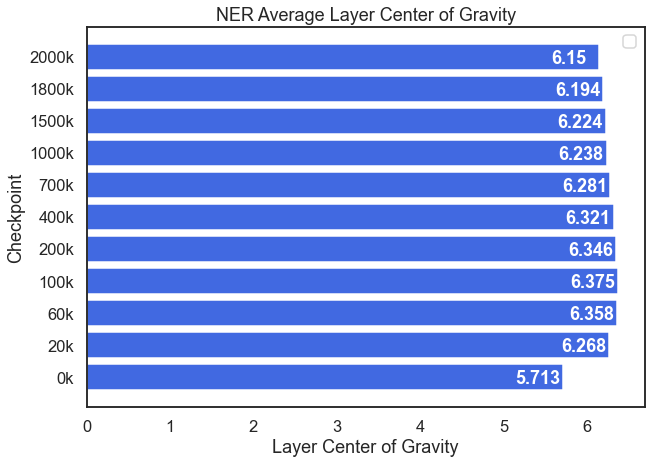

No handles with labels found to put in legend.


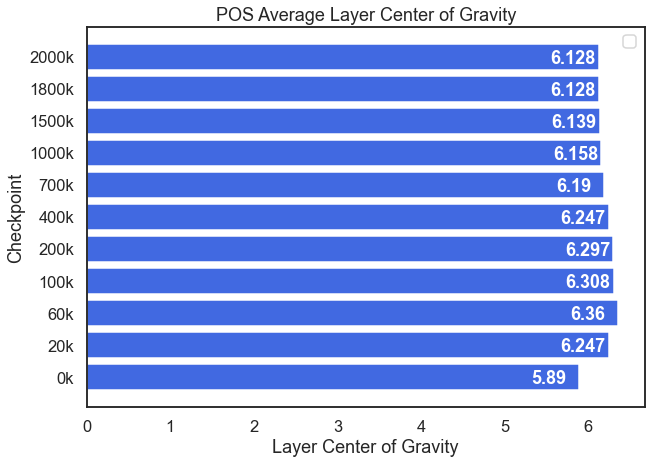

No handles with labels found to put in legend.


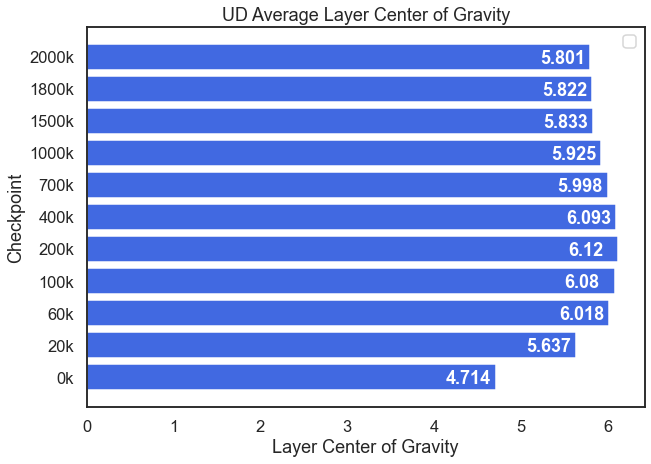

No handles with labels found to put in legend.


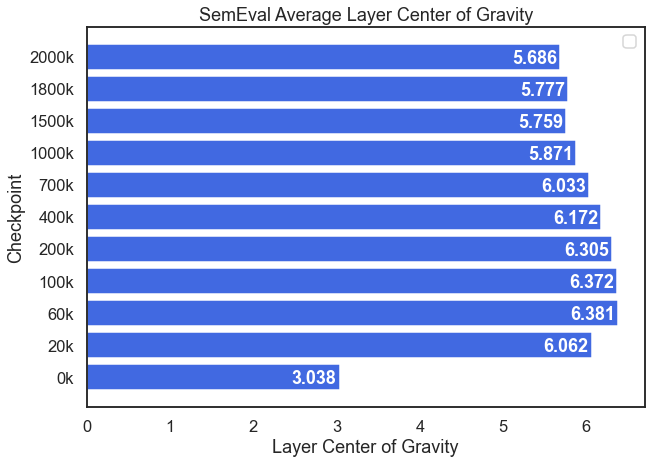

In [96]:
for i, weight in enumerate(weights_fine):
    plot_cog(seeds_fine, checkpoints_fine, weights_fine[weight], task_names_fine[i])

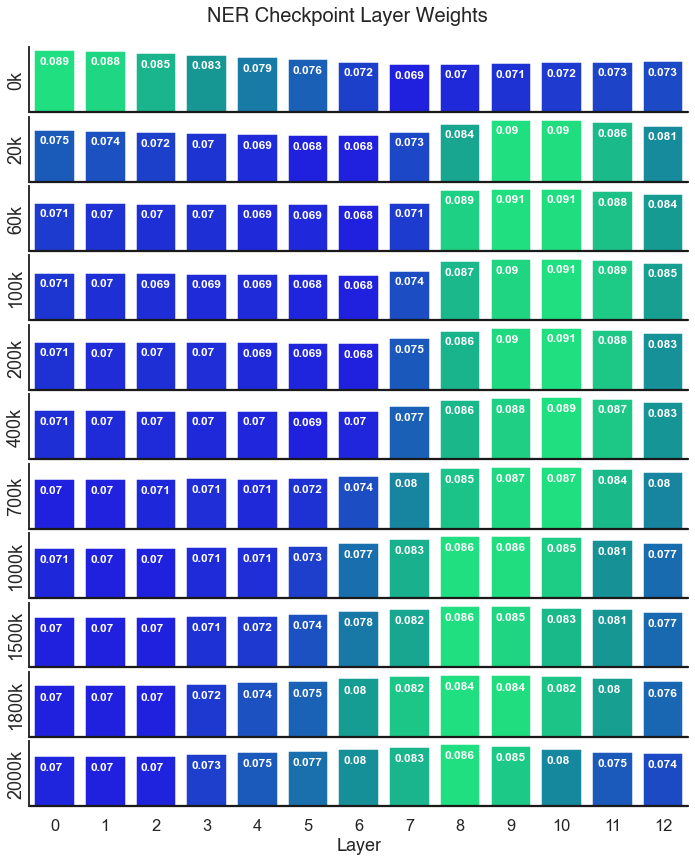

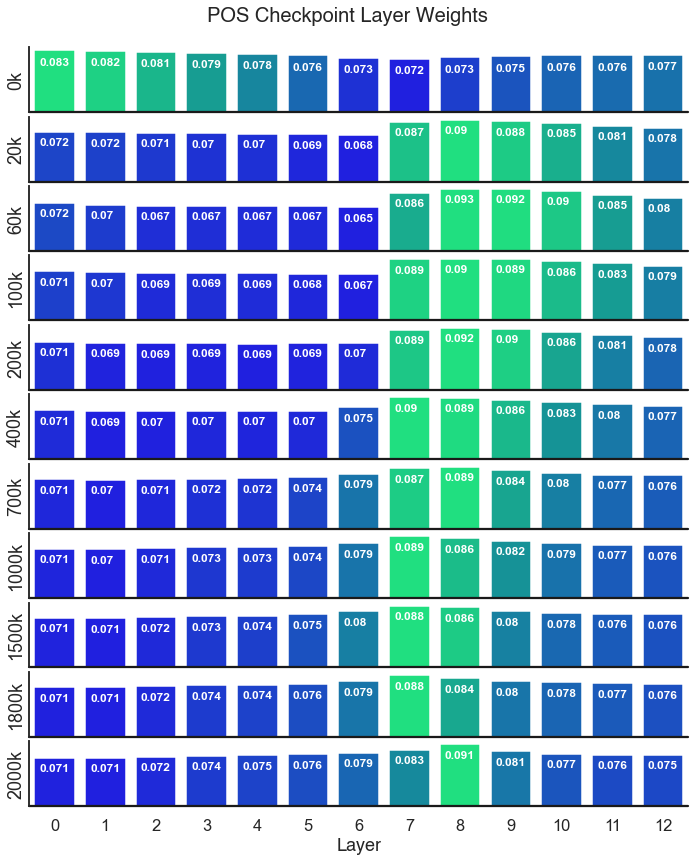

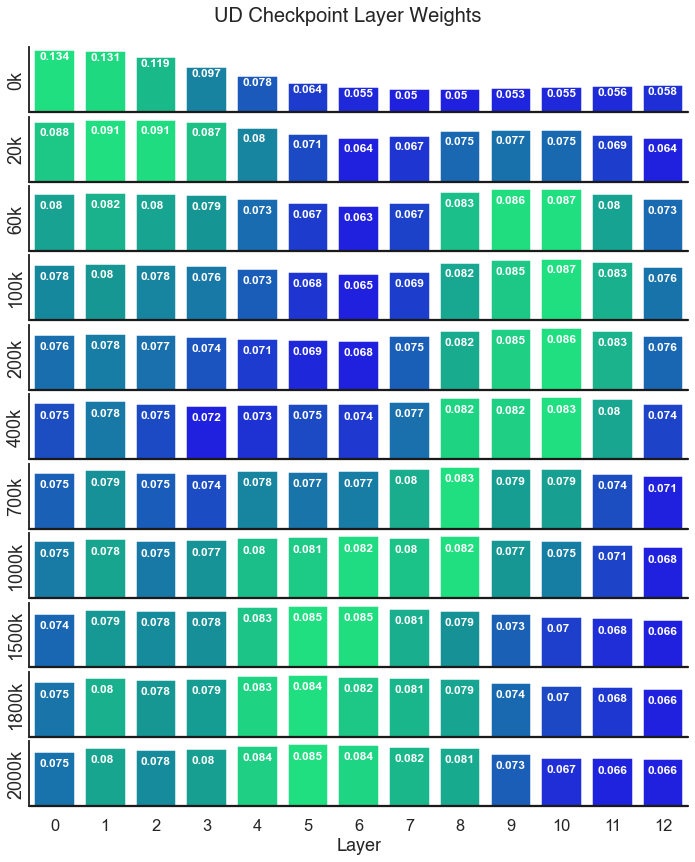

In [97]:
for i, weight in enumerate(weights_fine):
    plot_layer_weight(seeds_fine, checkpoints_fine, weights_fine[weight], task_names_fine[i])

In [114]:
weights_dfs_fine = {weight: weights_df(seeds_fine, checkpoints_fine, weights_fine[weight]) for weight in weights_fine}

In [115]:
compare_cogs(weights_fine, ['semeval', 'coref', 'ner', 'pos'], 
             ['SemEval', 'Coref.', 'NER', 'POS'])

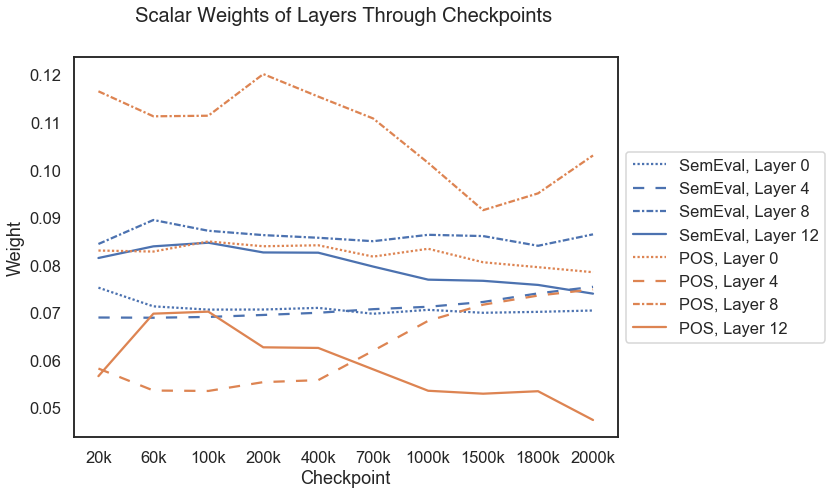

In [100]:
compare_weights(weights_fine, ['semeval', 'pos'], 
             ['SemEval', 'POS'], [0,4,8,12])

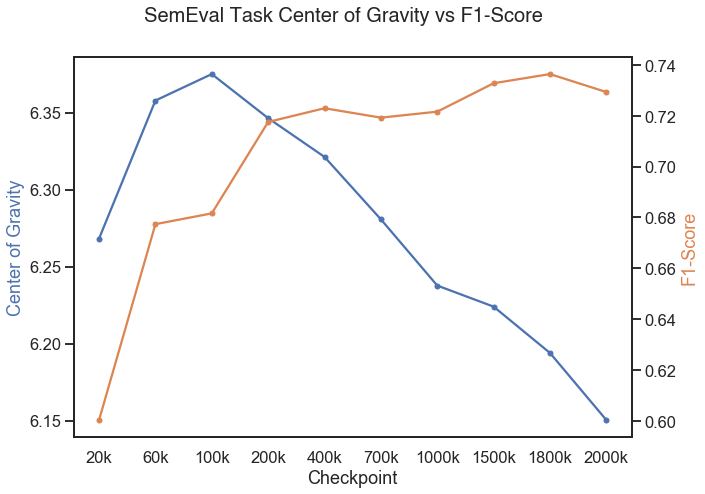

In [101]:
cog_vs_metric(weights_fine['semeval'], dfs_fine['semeval'], 'SemEval', 'F1-Score')

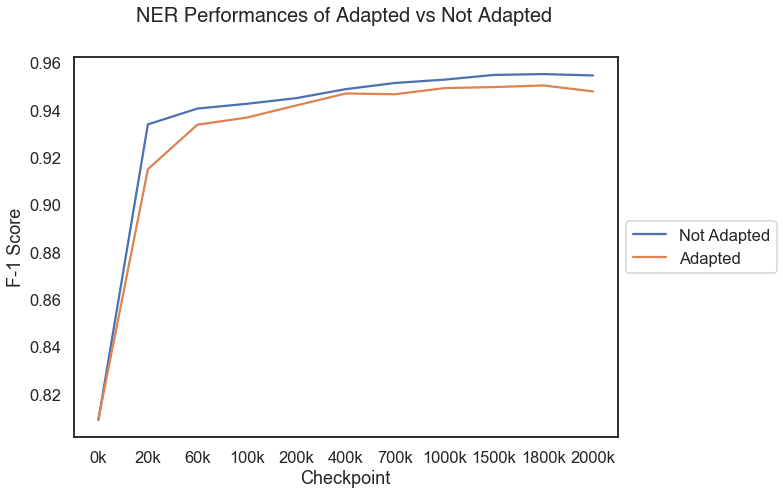

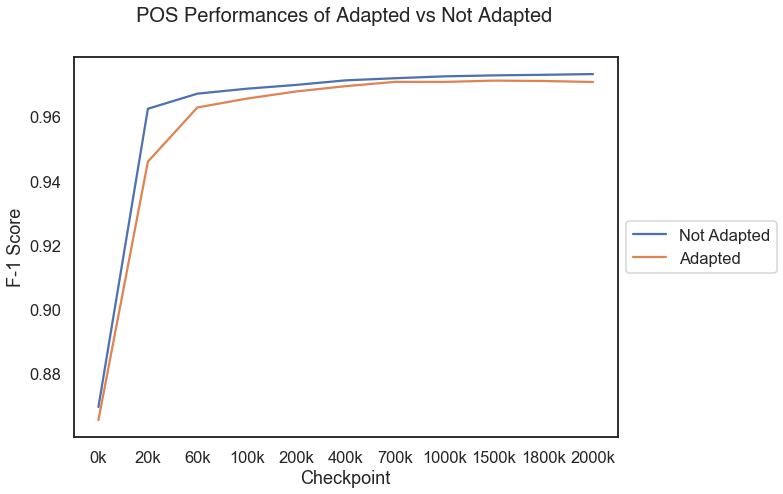

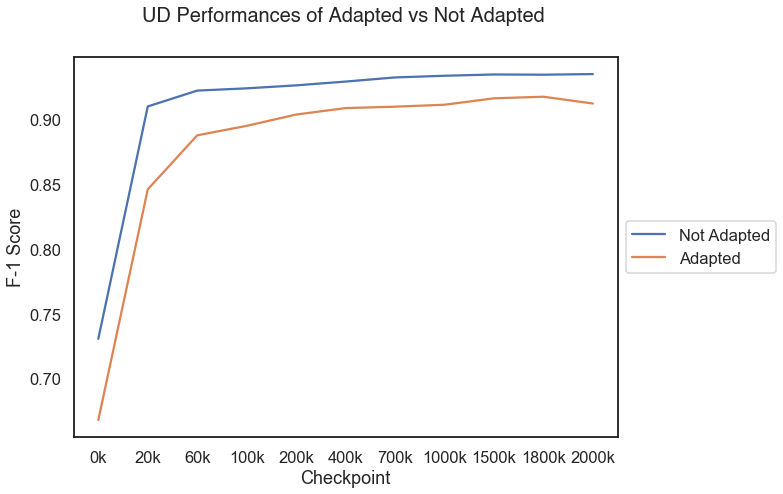

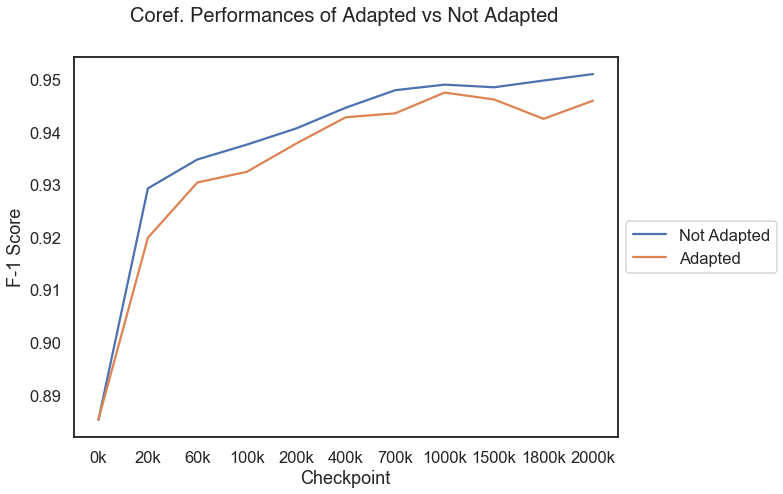

KeyError: 'srl'

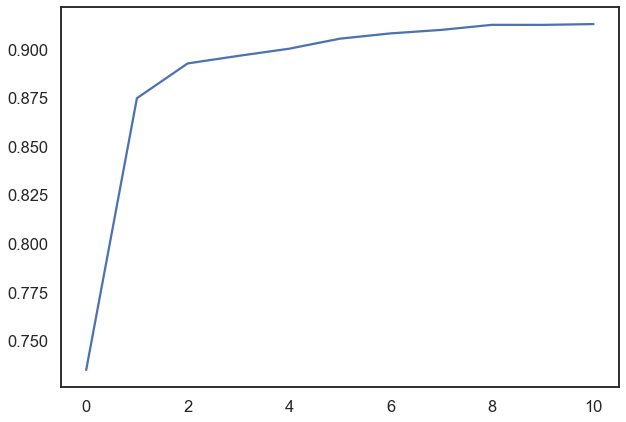

In [144]:
tasks_fine = ['ner', 'pos', 'ud', 'coref', 'srl']
task_names_fine = ['NER', 'POS', 'UD', 'Coref.', 'SRL']

for i, task in enumerate(['ontonotes/ner', 'ontonotes/pos', 'ud', 'ontonotes/coref', 'ontonotes/srl']):
    compare_finetuned_performance(dfs, dfs_fine, task, 
                                  tasks_fine[i], task_names_fine[i])

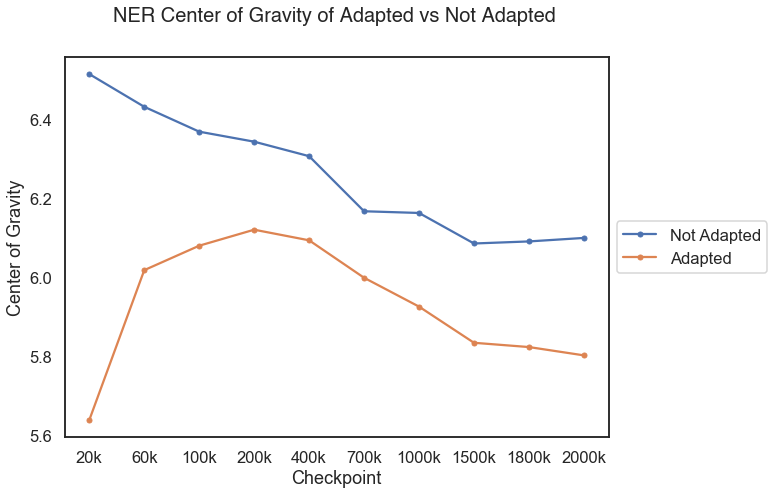

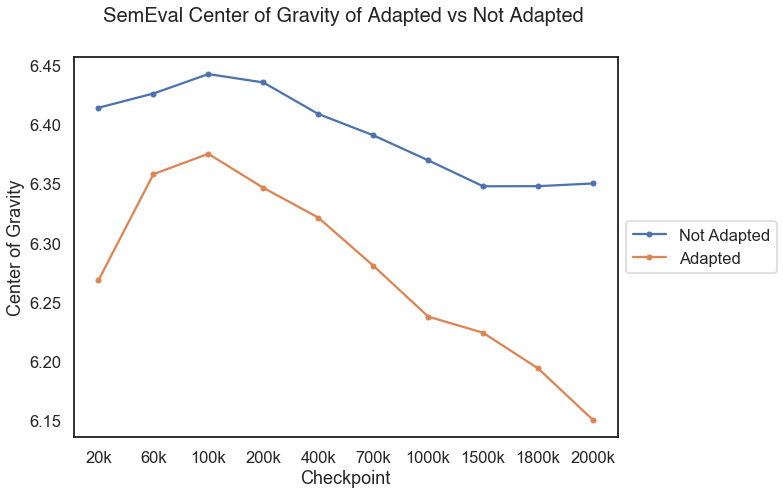

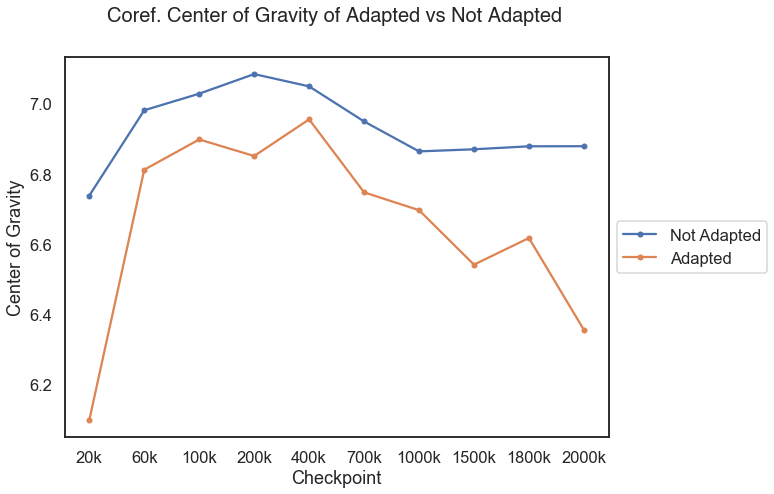

In [130]:
tasks_fine = ['ner', 'pos', 'ud', 'semeval', 'coref']
task_names_fine = ['NER', 'POS', 'UD', 'SemEval', 'Coref.']

for i, task in enumerate(['ontonotes/ner', 'ontonotes/pos', 'ud', 'semeval', 'ontonotes/coref']):
    compare_finetuned_cogs(weights, weights_fine, task, 
                                  tasks_fine[i], task_names_fine[i])